In [44]:
import os
import torch
from torch_geometric import utils
import networkx as nx
from gensim.models import Word2Vec
import math
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from torch import nn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import f1_score
from node2vec import Node2Vec
from helpers import *
from tqdm import tqdm
import time
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Deepwalk Implementation

In this notebook, we will implement the deepwalk algorithm for node embedding. The paper is here: https://arxiv.org/abs/1403.6652

We will analyze the performance of deepwalk on the following dataset for fraud detection: XXX

In [39]:
class DeepWalk():
    
    
    '''
    Using this class: after initializing, run the generate_walks method to generate the random walks. 
    To generate the embeddings, run the skipgram method. 
    
    '''
    def __init__(self, G: nx.Graph , window: int, dims: int, num_walks: int, walk_length: int):
        '''
        G: the graph of which the node embeddings will be created
        window: the window size
        dims: the embedding size
        num_walks: The number of random walks performed for each individual node
        walk_length: The random walk length
        '''
        self.G = G
        self.window = window
        self.dims = dims
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.walks = None
        
        
    def generate_walks(self):
        '''
        Generating the walks
        '''
        #################
        # TODO
        #################
        
        #### initialize the vertex representation function
        # How I understand it, the vertex representations are the weights of the hidden layer in a 2 Layer NN
        # This initialization would then just be the random initialization of the weights. 
        
        #### Build a binary tree from the vertices: the Huffman tree
        
        #################
        
        
        # store all vertices 
        V = list(self.G.nodes)
        self.walks = []
        for _ in range(self.num_walks):
            # each iteration here makes a pass over the data to sample one walk for each node
            # the random order of the vertices speeds up the convergence of SGD
            random.shuffle(V)
            for v in V:
                # yields a generator object
                self.walks.append(self.RandomWalk(v))
        
        return self.walks
                
    
    def RandomWalk(self, v):
        # v is the root
        walk = [v]
        current = v
        for _ in range(self.walk_length):
            # neighbors of the current node
            neighbors = [node for node in self.G.neighbors(current)]
            # choose a neighbor to go to
            current = np.random.choice(neighbors)
            walk.append(current)

        return walk
    
    
    def skipgram(self):
        '''
        Calling the Word2Vec model that we will implement ourselves
        '''
            
        model = Word2Vec(sentences=self.walks, vector_size=self.dims, window=self.window, workers=4)
        
        # return the embeddings (word vectors)
        return model.wv
            
            

## A quick proof-of-concept with the karate dataset as used in the paper

The plot here does not correspond to the plot in the paper, might be a mistake in our code, or just a changed implementation of Word2Vec,...


Word2Vec source code: https://github.com/RaRe-Technologies/gensim/blob/develop/gensim/models/word2vec.py

DeepWalk source code: https://github.com/phanein/deepwalk

Embedding Time = 0.07225298881530762
TSNE succesfully applied: x now of shape: (34, 2)


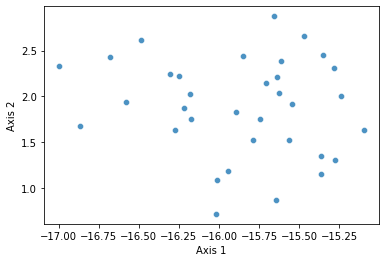

<Figure size 720x720 with 0 Axes>

In [3]:
G = nx.read_gml("karate.gml")


# Hyperparameters
window = 5
dims = 2
num_walks = 10
walk_length = 15

# Completing DeepWalk embeddings, testing efficiency, and visualizing embeddings in 2-d space
start = time.time()
deepwalk = DeepWalk(G, window=window, dims=dims, num_walks=num_walks, walk_length=walk_length)
walks = deepwalk.generate_walks()
embeddings = deepwalk.skipgram()
end = time.time()
print("Embedding Time = %s" % (end - start))

visualize(G, embeddings)

## Now, importing and testing on a larger dataset.

Data source: https://github.com/pygod-team/data

In [40]:
path = 'inj_cora.pt'
G = read_from_pyg(path)

Embedding Time = 1.910017728805542
TSNE succesfully applied: x now of shape: (2708, 2)


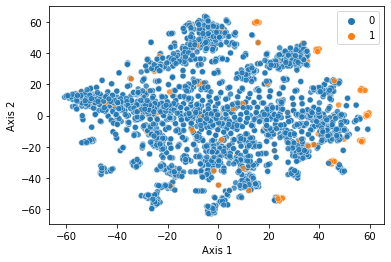

<Figure size 720x720 with 0 Axes>

In [61]:
# Hyperparameters
window = 2
dims = 128
num_walks = 3
walk_length = 20

# Completing DeepWalk embeddings, testing efficiency, and visualizing embeddings in 2-d space
start = time.time()
deepwalk = DeepWalk(G, window=window, dims=dims, num_walks=num_walks, walk_length=walk_length)
walks = deepwalk.generate_walks()
embeddings = deepwalk.skipgram()
end = time.time()
print("Embedding Time = %s" % (end - start))

visualize(G, embeddings, labeled=True)

# Classification Task using Embeddings

Using this to test how our embeddings perform on the classification tasks, using a generic logistic regression.

If we get an error here, it is because node all nodes were visited on the random walks (you'll get an error saying that the dimensions don't match up). Just increase the walk length or number of walks.

Keeping track of the indices of the samples in training and test to keep test sets consistent over different models. 

Binary test F1: 0.3846153846153846
Macro test F1: 0.6596546310832025


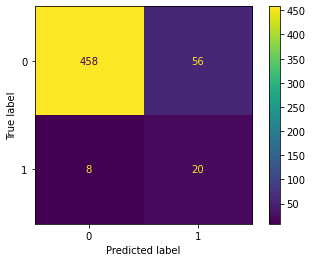

In [62]:
y_train, y_test = predict(G,embeddings, model = 'lr', return_train_test = True)

Binary test F1: 0.6363636363636364
Macro test F1: 0.8104895104895105


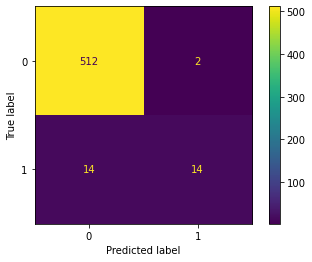

In [63]:
predict(G,embeddings, model = 'xgb')

### Gridsearch on XGBoost

In [10]:
y = list(nx.get_node_attributes(G, 'y').values())

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, shuffle=True, stratify=y)

In [15]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
pos_samples = sum(y)
neg_samples = len(y) - pos_samples

param_grid = parameters = {'max_depth': [5,10,15], 'lambda':[1, 10], 'scale_pos_weight': [neg_samples/pos_samples]}
xgb = XGBClassifier()
gridsearch = GridSearchCV(xgb, parameters, scoring = 'f1')
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'lambda': [1, 10], 'max_depth': [5, 10, 15],
                         'scale_pos_weight': [18.6231884057971]},
             scoring='f1')

In [17]:
print(gridsearch.cv_results_)
print(gridsearch.best_params_)

{'mean_fit_time': array([0.41237054, 0.57288861, 0.45849371, 0.50682549, 0.613063  ,
       0.63048434]), 'std_fit_time': array([0.01755049, 0.0617092 , 0.00388279, 0.02172387, 0.01079255,
       0.00736573]), 'mean_score_time': array([0.00579014, 0.00612273, 0.00508289, 0.00548539, 0.00529337,
       0.00545502]), 'std_score_time': array([0.00075734, 0.00129203, 0.00017186, 0.00062992, 0.00062901,
       0.00067921]), 'param_lambda': masked_array(data=[1, 1, 1, 10, 10, 10],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_max_depth': masked_array(data=[5, 10, 15, 5, 10, 15],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_scale_pos_weight': masked_array(data=[18.6231884057971, 18.6231884057971, 18.6231884057971,
                   18.6231884057971, 18.6231884057971, 18.6231884057971],
             mask=[False, False, False, False, False, False],


  0%|          | 0/24 [00:00<?, ?it/s]

Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.15469613259668508
Macro test F1: 0.4926304583249206


  4%|▍         | 1/24 [00:29<11:19, 29.54s/it]

Binary test F1: 0.43243243243243246
Macro test F1: 0.7061875629210873
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.18633540372670804
Macro test F1: 0.522203454842769


  8%|▊         | 2/24 [01:10<13:18, 36.27s/it]

Binary test F1: 0.1951219512195122
Macro test F1: 0.5817412248906765
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.20111731843575417
Macro test F1: 0.5215531343559986


 12%|█▎        | 3/24 [02:23<18:31, 52.93s/it]

Binary test F1: 0.5238095238095237
Macro test F1: 0.7523078329220363
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.2091503267973856
Macro test F1: 0.5395912751065338


 17%|█▋        | 4/24 [04:05<24:10, 72.51s/it]

Binary test F1: 0.25641025641025644
Macro test F1: 0.6143295301190038
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.20382165605095542
Macro test F1: 0.5344890373027161


 21%|██        | 5/24 [04:35<18:07, 57.23s/it]

Binary test F1: 0.4
Macro test F1: 0.6885057471264369
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.21301775147928992
Macro test F1: 0.5338312801112297


 25%|██▌       | 6/24 [05:17<15:31, 51.77s/it]

Binary test F1: 0.3157894736842105
Macro test F1: 0.6454664385629465
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.21538461538461542
Macro test F1: 0.5542331881954524


 29%|██▉       | 7/24 [06:31<16:45, 59.14s/it]

Binary test F1: 0.45000000000000007
Macro test F1: 0.714463601532567
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.18633540372670804
Macro test F1: 0.522203454842769


 33%|███▎      | 8/24 [08:14<19:32, 73.25s/it]

Binary test F1: 0.2857142857142857
Macro test F1: 0.6309410322756367
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.33043478260869563
Macro test F1: 0.625485709157805


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 38%|███▊      | 9/24 [08:49<15:19, 61.30s/it]

Binary test F1: 0.5333333333333333
Macro test F1: 0.7565607956368303
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.3392857142857143
Macro test F1: 0.631577013521458


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 42%|████▏     | 10/24 [09:37<13:17, 56.94s/it]

Binary test F1: 0.41860465116279066
Macro test F1: 0.6972946406630476
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.28571428571428575
Macro test F1: 0.6073601854534918


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
 46%|████▌    

Binary test F1: 0.4
Macro test F1: 0.6885057471264369
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.24390243902439024
Macro test F1: 0.5910130957597002


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 50%|█████     | 12/24 [12:56<16:07, 80.60s/it]

Binary test F1: 0.2777777777777778
Macro test F1: 0.6264843087362171
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.17647058823529413
Macro test F1: 0.5291635641598412


 54%|█████▍    | 13/24 [13:27<11:59, 65.37s/it]

Binary test F1: 0.2777777777777778
Macro test F1: 0.6264843087362171
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.2631578947368421
Macro test F1: 0.5714931104585498


 58%|█████▊    | 14/24 [14:09<09:43, 58.36s/it]

Binary test F1: 0.46511627906976744
Macro test F1: 0.7215110694100038
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.17857142857142858
Macro test F1: 0.5139582033686837


 62%|██████▎   | 15/24 [15:24<09:31, 63.46s/it]

Binary test F1: 0.2285714285714286
Macro test F1: 0.6014163148576877
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.20238095238095238
Macro test F1: 0.5280463713869827


 67%|██████▋   | 16/24 [17:09<10:06, 75.87s/it]

Binary test F1: 0.25641025641025644
Macro test F1: 0.6143295301190038
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.16326530612244897
Macro test F1: 0.5159976477250452


 71%|███████   | 17/24 [17:40<07:17, 62.45s/it]

Binary test F1: 0.48780487804878053
Macro test F1: 0.7338353249304306
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.2638888888888889
Macro test F1: 0.5755614657210402


 75%|███████▌  | 18/24 [18:23<05:39, 56.57s/it]

Binary test F1: 0.3684210526315789
Macro test F1: 0.6727382509811815
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.2236842105263158
Macro test F1: 0.5485373842331149


 79%|███████▉  | 19/24 [19:39<05:12, 62.51s/it]

Binary test F1: 0.24242424242424243
Macro test F1: 0.6093186863881441
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.2285714285714286
Macro test F1: 0.5570823244552058


 83%|████████▎ | 20/24 [21:26<05:03, 75.79s/it]

Binary test F1: 0.2702702702702703
Macro test F1: 0.6222411523271123
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.1869158878504673
Macro test F1: 0.5489338907010781


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 88%|████████▊ | 21/24 [22:03<03:12, 64.23s/it]

Binary test F1: 0.3902439024390244
Macro test F1: 0.6831372915838458
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.24742268041237112
Macro test F1: 0.5867305904594783


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 92%|█████████▏| 22/24 [22:55<02:01, 60.51s/it]

Binary test F1: 0.4285714285714286
Macro test F1: 0.7027693995064437
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.2978723404255319
Macro test F1: 0.6156028368794326


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 96%|█████████▌| 23/24 [24:25<01:09, 69.27s/it]

Binary test F1: 0.24242424242424243
Macro test F1: 0.6093186863881441
Embedding Time = <module 'time' (built-in)>
Binary test F1: 0.2241379310344828
Macro test F1: 0.5655813622114563


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 24/24 [29:08<00:00, 72.83s/it] 

Binary test F1: 0.29411764705882354
Macro test F1: 0.6356302521008403


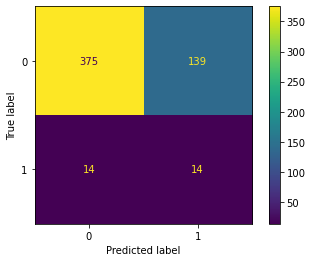

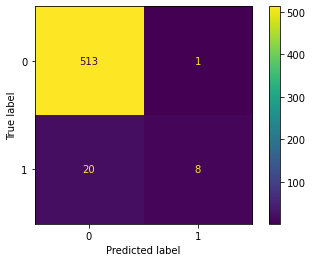

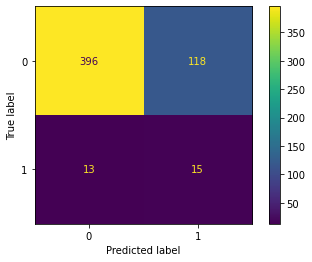

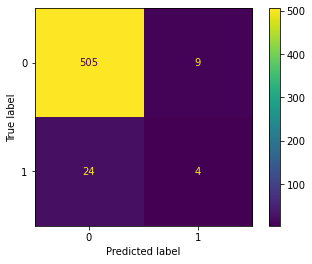

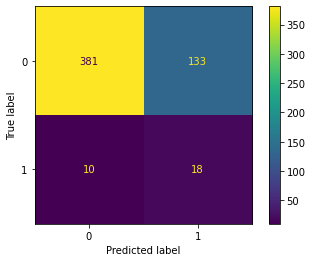

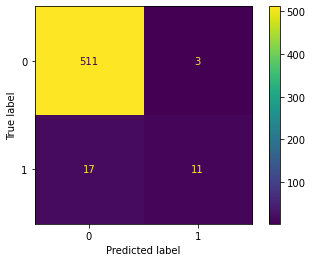

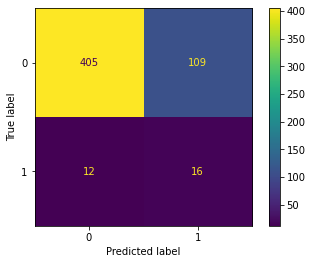

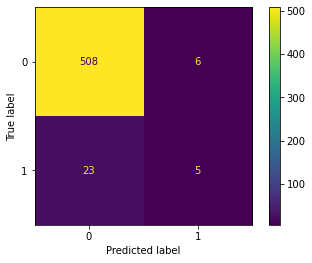

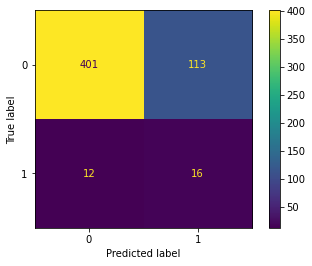

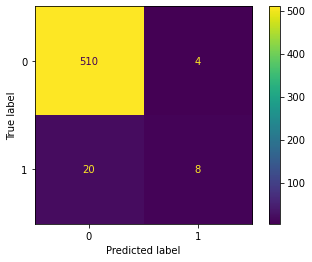

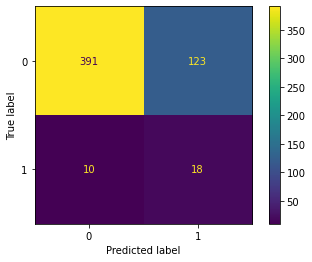

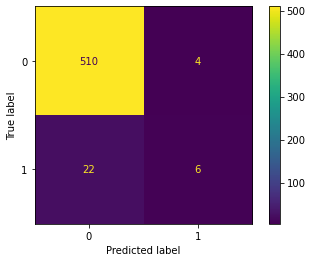

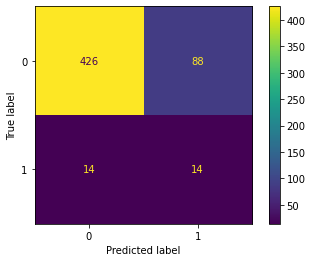

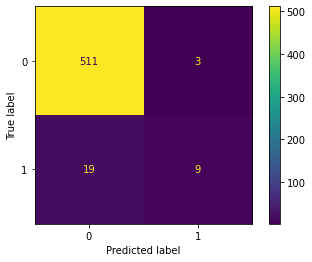

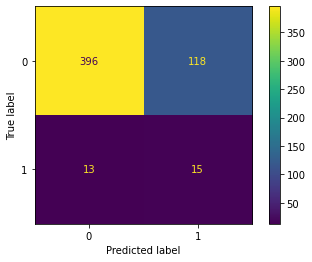

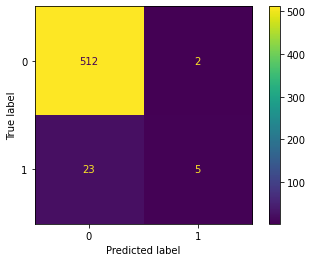

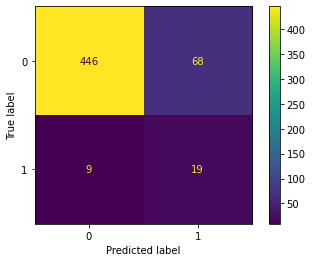

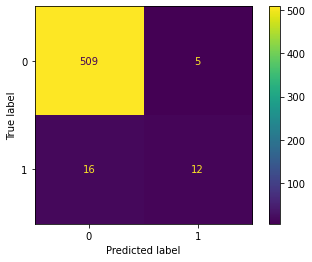

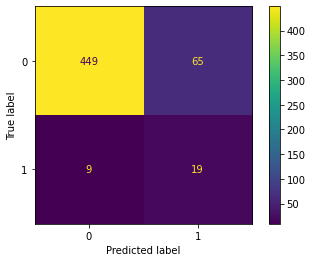

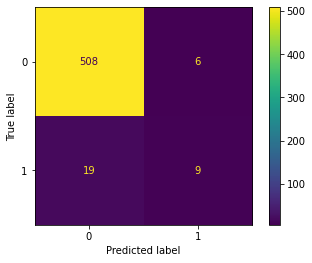

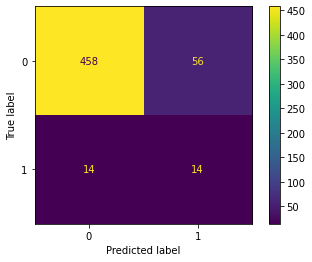

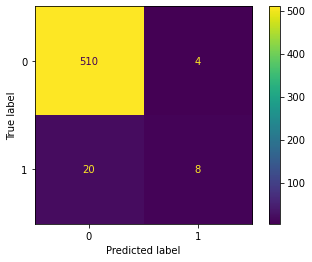

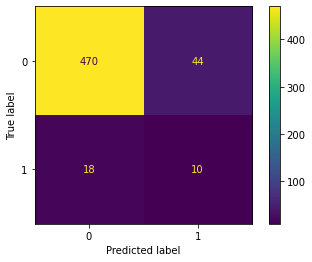

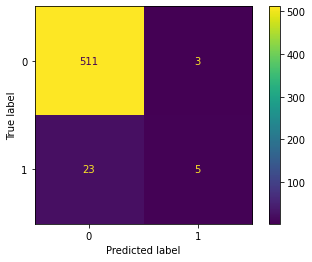

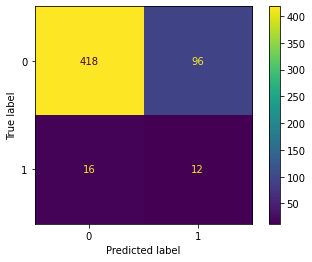

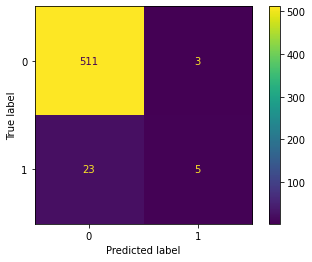

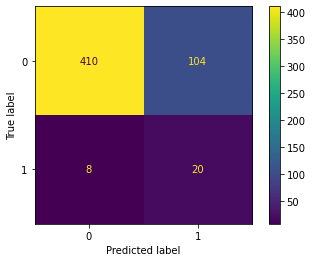

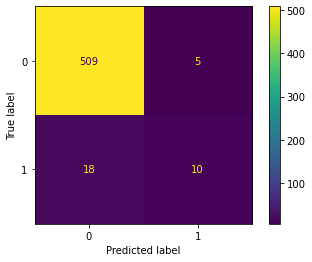

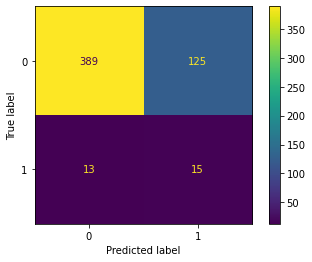

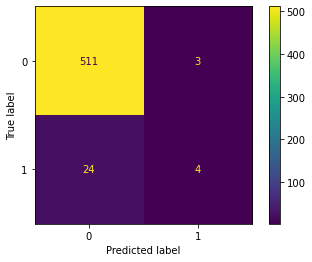

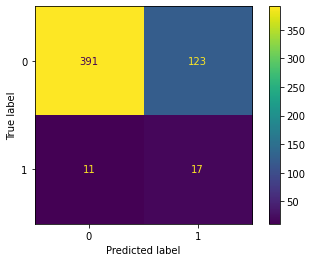

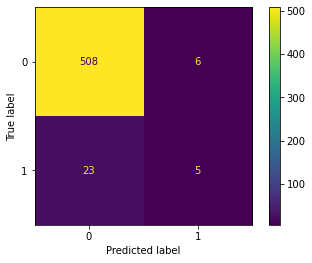

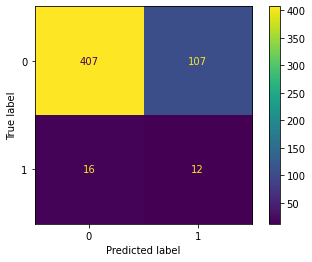

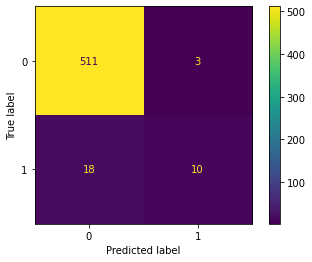

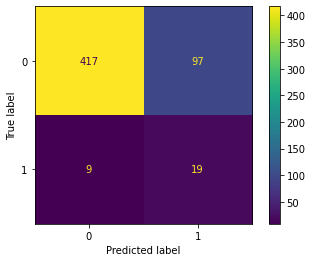

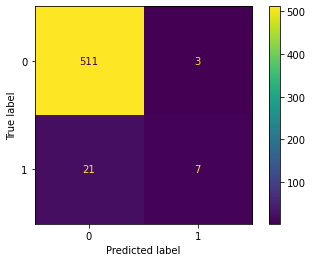

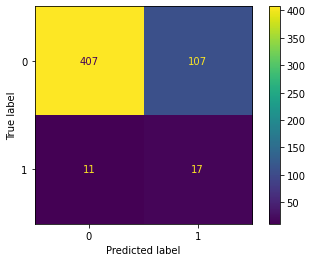

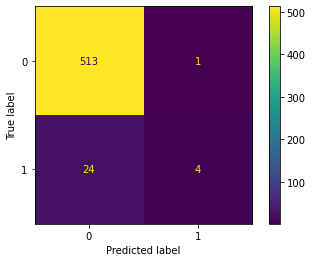

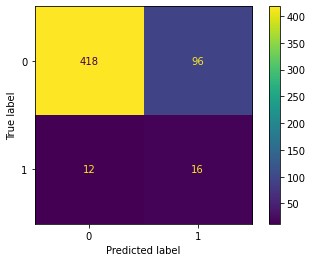

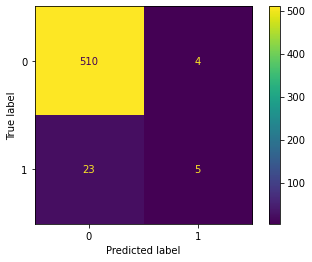

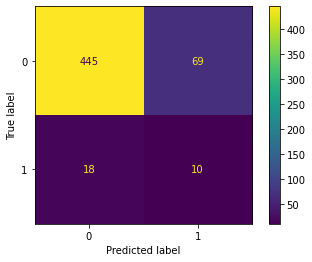

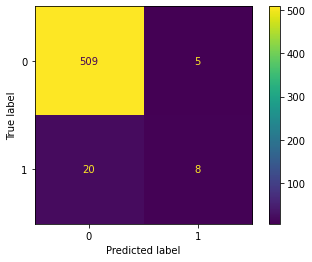

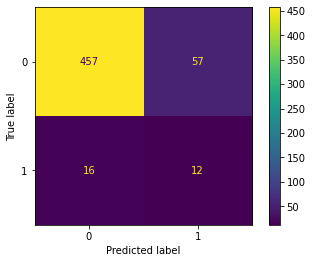

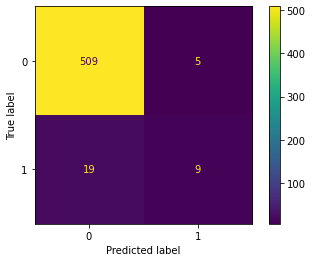

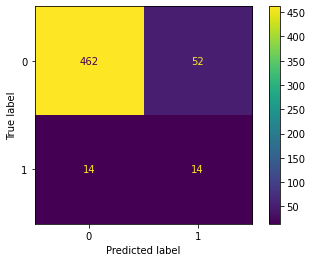

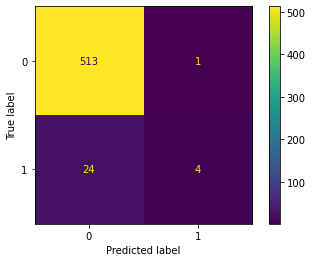

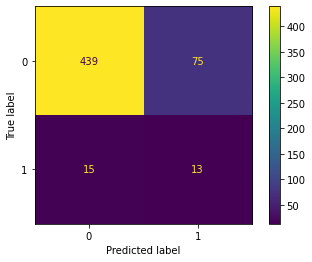

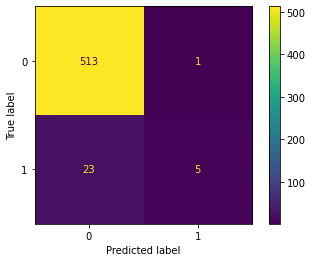

In [46]:
windws = [2,5]
dimensions = [50,100,500] 
num_walks = [20,50]
walk_length = [50,70]

combinations = list(itertools.product(windws, dimensions, num_walks, walk_length))
binary_f1_scores_lr = []
macro_f1_scores_lr = []
binary_f1_scores_xgb = []
macro_f1_scores_xgb = []
final_combinations = []
times = []

for comb in tqdm(combinations):
    window = comb[0]
    dims = comb[1]
    num_walks = comb[2]
    walk_length = comb[3]
    
    try:
        start = time.time()
        deepwalk = DeepWalk(G, window=window, dims=dims, num_walks=num_walks, walk_length=walk_length)
        walks = deepwalk.generate_walks()
        embeddings = deepwalk.skipgram()
        end = time.time()
        duration = end-start
        print("Embedding Time = %s" % (time))
        binary_f1_lr, macro_f1_lr = predict(G,embeddings, return_f1_score = True, model = 'lr')
        binary_f1_xgb, macro_f1_xgb = predict(G,embeddings, return_f1_score = True, model = 'xgb')
        binary_f1_scores_lr.append(binary_f1_lr)  
        macro_f1_scores_lr.append(macro_f1_lr)
        binary_f1_scores_xgb.append(binary_f1_xgb)  
        macro_f1_scores_xgb.append(macro_f1_xgb)
        final_combinations.append(comb)
        times.append(duration)
    except:
        print('Failed')
        continue

In [51]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1 Logistic Regression"] = binary_f1_scores_lr
df["Test Macro F1 Logistic Regression"] = macro_f1_scores_lr
df["Test Binary F1 XGB"] = binary_f1_scores_xgb
df["Test Macro F1 XGB"] = macro_f1_scores_xgb
df["Duration"] = times # More walks takes a longer time
df.rename(columns = {0: 'Window',
                     1: "Dimension",
                     2: "Number of walks",
                     3: "Walk Length"}, inplace = True)
df = df.sort_values(by=['Test Binary F1 XGB'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(30)

,Window,Dimension,Number of walks,Walk Length,Test Binary F1 Logistic Regression,Test Macro F1 Logistic Regression,Test Binary F1 XGB,Test Macro F1 XGB,Duration
0,2,500,20,50,0.330435,0.625486,0.533333,0.756561,32.639794
1,2,50,50,50,0.201117,0.521553,0.523810,0.752308,72.323528
2,5,100,20,50,0.163265,0.515998,0.487805,0.733835,30.600745
3,5,50,20,70,0.263158,0.571493,0.465116,0.721511,41.623211
4,2,100,50,50,0.215385,0.554233,0.450000,0.714464,73.565623
5,2,50,20,50,0.154696,0.492630,0.432432,0.706188,29.134766
6,5,500,20,70,0.247423,0.586731,0.428571,0.702769,49.725574
7,2,500,20,70,0.339286,0.631577,0.418605,0.697295,44.939908
8,2,100,20,50,0.203822,0.534489,0.400000,0.688506,29.550904
9,2,500,50,50,0.285714,0.607360,0.400000,0.688506,81.470426


  0%|          | 0/1 [00:00<?, ?it/s]

Embedding Time = 44.15945029258728
Binary test F1: 0.2828282828282828
Macro test F1: 0.6053735322770856


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.3902439024390244
Macro test F1: 0.6831372915838458
Embedding Time = 45.009907245635986
Binary test F1: 0.31007751937984496
Macro test F1: 0.608441901051179


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.4
Macro test F1: 0.6885057471264369
Embedding Time = 45.005756855010986
Binary test F1: 0.26086956521739124
Macro test F1: 0.5961605890603086


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.4
Macro test F1: 0.6885057471264369
Embedding Time = 45.37728309631348
Binary test F1: 0.3181818181818182
Macro test F1: 0.6289704271631983


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.41860465116279066
Macro test F1: 0.6972946406630476
Embedding Time = 45.39456510543823
Binary test F1: 0.29059829059829057
Macro test F1: 0.60238290951838


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.45000000000000007
Macro test F1: 0.714463601532567
Embedding Time = 45.28992795944214
Binary test F1: 0.339622641509434
Macro test F1: 0.6340239996913223


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.4102564102564102
Macro test F1: 0.6941234204392099
Embedding Time = 45.22008299827576
Binary test F1: 0.2469135802469136
Macro test F1: 0.5930480164444937


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.30769230769230765
Macro test F1: 0.6409274935590725
Embedding Time = 45.15127921104431
Binary test F1: 0.19047619047619047
Macro test F1: 0.5518264507028552


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.3333333333333333
Macro test F1: 0.6552162849872774
Embedding Time = 45.61505913734436
Binary test F1: 0.3106796116504854
Macro test F1: 0.6191522421147433


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.4285714285714286
Macro test F1: 0.7027693995064437
Embedding Time = 45.824424028396606
Binary test F1: 0.32653061224489793
Macro test F1: 0.6297967462847208


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 1/1 [07:52<00:00, 472.71s/it]

Binary test F1: 0.3333333333333333
Macro test F1: 0.6552162849872774


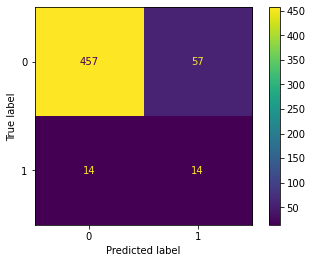

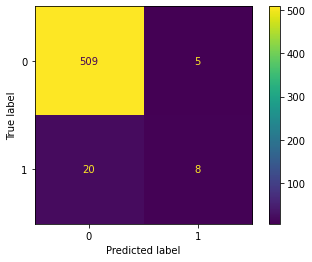

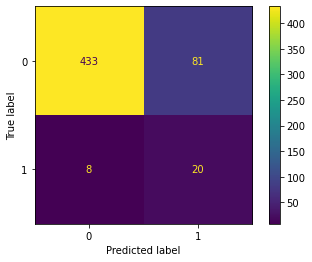

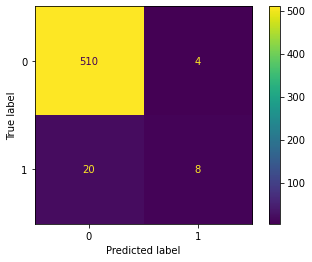

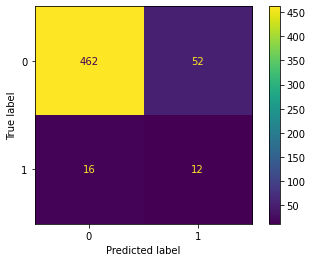

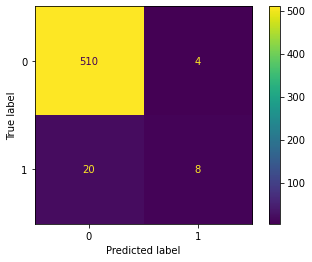

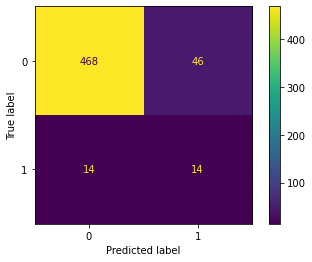

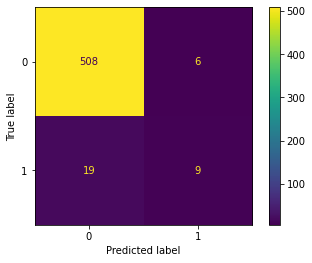

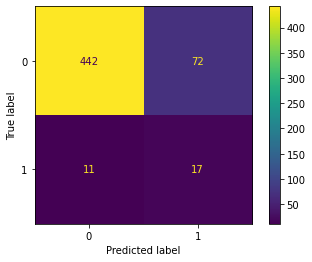

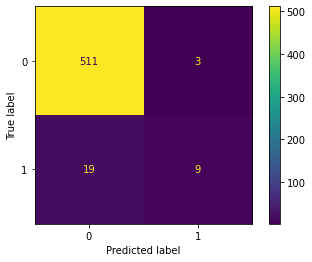

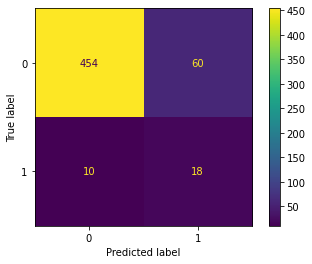

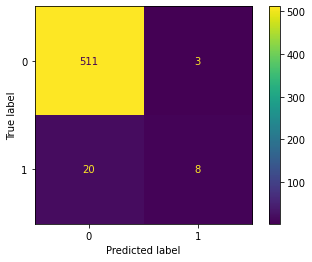

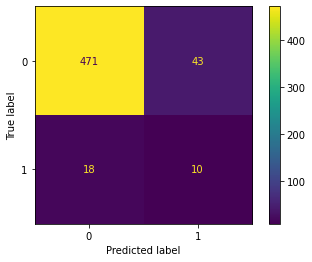

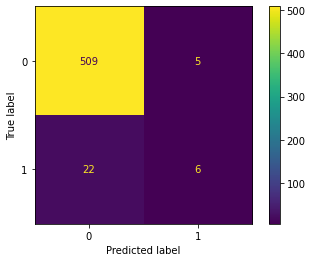

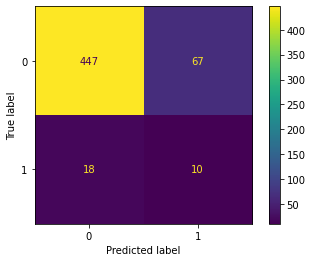

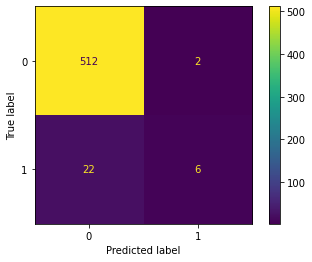

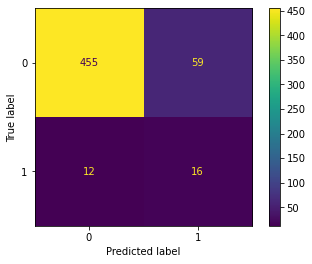

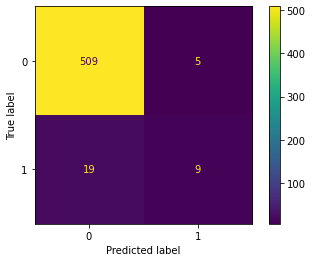

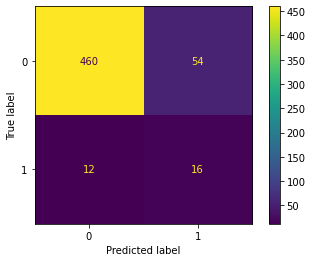

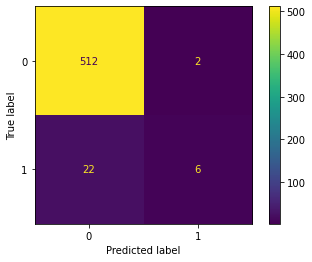

In [52]:
windws = [2]
dimensions = [500] 
num_walks = [20]
walk_length = [70]

combinations = list(itertools.product(windws, dimensions, num_walks, walk_length))
binary_f1_scores_lr = []
macro_f1_scores_lr = []
binary_f1_scores_xgb = []
macro_f1_scores_xgb = []
final_combinations = []
times = []

for comb in tqdm(combinations):
    window = comb[0]
    dims = comb[1]
    num_walks = comb[2]
    walk_length = comb[3]
    for _ in range(10):
        try:
            start = time.time()
            deepwalk = DeepWalk(G, window=window, dims=dims, num_walks=num_walks, walk_length=walk_length)
            walks = deepwalk.generate_walks()
            embeddings = deepwalk.skipgram()
            end = time.time()
            duration = end-start
            print("Embedding Time = %s" % (duration))
            binary_f1_lr, macro_f1_lr = predict(G,embeddings, return_f1_score = True, model = 'lr')
            binary_f1_xgb, macro_f1_xgb = predict(G,embeddings, return_f1_score = True, model = 'xgb')
            binary_f1_scores_lr.append(binary_f1_lr)  
            macro_f1_scores_lr.append(macro_f1_lr)
            binary_f1_scores_xgb.append(binary_f1_xgb)  
            macro_f1_scores_xgb.append(macro_f1_xgb)
            final_combinations.append(comb)
            times.append(duration)
        except:
            print('Failed')
            continue

In [53]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1 Logistic Regression"] = binary_f1_scores_lr
df["Test Macro F1 Logistic Regression"] = macro_f1_scores_lr
df["Test Binary F1 XGB"] = binary_f1_scores_xgb
df["Test Macro F1 XGB"] = macro_f1_scores_xgb
df["Duration"] = times # More walks takes a longer time
df.rename(columns = {0: 'Window',
                     1: "Dimension",
                     2: "Number of walks",
                     3: "Walk Length"}, inplace = True)
df = df.sort_values(by=['Test Binary F1 XGB'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(10)

,Window,Dimension,Number of walks,Walk Length,Test Binary F1 Logistic Regression,Test Macro F1 Logistic Regression,Test Binary F1 XGB,Test Macro F1 XGB,Duration
0,2,500,20,70,0.290598,0.602383,0.450000,0.714464,45.394565
1,2,500,20,70,0.310680,0.619152,0.428571,0.702769,45.615059
2,2,500,20,70,0.318182,0.628970,0.418605,0.697295,45.377283
3,2,500,20,70,0.339623,0.634024,0.410256,0.694123,45.289928
4,2,500,20,70,0.310078,0.608442,0.400000,0.688506,45.009907
5,2,500,20,70,0.260870,0.596161,0.400000,0.688506,45.005757
6,2,500,20,70,0.282828,0.605374,0.390244,0.683137,44.159450
7,2,500,20,70,0.190476,0.551826,0.333333,0.655216,45.151279
8,2,500,20,70,0.326531,0.629797,0.333333,0.655216,45.824424
9,2,500,20,70,0.246914,0.593048,0.307692,0.640927,45.220083


  0%|          | 0/12 [00:00<?, ?it/s]

Embedding Time = 4.52020001411438
Binary test F1: 0.25757575757575757
Macro test F1: 0.5773172905525846


  8%|▊         | 1/12 [00:05<00:58,  5.34s/it]

Binary test F1: 0.3243243243243243
Macro test F1: 0.6502232891917705
Embedding Time = 6.229934930801392
Binary test F1: 0.21897810218978103
Macro test F1: 0.5529948589090404


 17%|█▋        | 2/12 [00:12<01:02,  6.25s/it]

Binary test F1: 0.35555555555555557
Macro test F1: 0.6638220511175276
Embedding Time = 7.37644100189209
Binary test F1: 0.29230769230769227
Macro test F1: 0.5979358168037412


 25%|██▌       | 3/12 [00:20<01:03,  7.06s/it]

Binary test F1: 0.5333333333333333
Macro test F1: 0.7565607956368303
Embedding Time = 10.382064819335938
Binary test F1: 0.25
Macro test F1: 0.5712025316455696


 33%|███▎      | 4/12 [00:31<01:09,  8.64s/it]

Binary test F1: 0.38095238095238093
Macro test F1: 0.6780001827986473
Embedding Time = 4.592930793762207
Binary test F1: 0.23076923076923075
Macro test F1: 0.5629737139171103


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 42%|████▏     | 5/12 [00:36<00:52,  7.51s/it]

Binary test F1: 0.4285714285714286
Macro test F1: 0.7027693995064437
Embedding Time = 6.356327056884766
Binary test F1: 0.25688073394495414
Macro test F1: 0.5869019054340155


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 50%|█████     | 6/12 [00:44<00:44,  7.44s/it]

Binary test F1: 0.5581395348837209
Macro test F1: 0.7699439269039161
Embedding Time = 7.5309388637542725
Binary test F1: 0.20833333333333337
Macro test F1: 0.5435283687943263


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 58%|█████▊    | 7/12 [00:52<00:38,  7.77s/it]

Binary test F1: 0.40909090909090917
Macro test F1: 0.6920454545454546
Embedding Time = 10.489360094070435
Binary test F1: 0.2302158273381295
Macro test F1: 0.5584941570553081


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 67%|██████▋   | 8/12 [01:04<00:35,  8.95s/it]

Binary test F1: 0.358974358974359
Macro test F1: 0.6675254569991412
Embedding Time = 5.1733880043029785
Binary test F1: 0.25196850393700787
Macro test F1: 0.5763499781962991


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 75%|███████▌  | 9/12 [01:11<00:25,  8.42s/it]

Binary test F1: 0.6190476190476191
Macro test F1: 0.8018462663376291
Embedding Time = 7.031882047653198
Binary test F1: 0.2982456140350877
Macro test F1: 0.6078856936154821


 83%|████████▎ | 10/12 [01:20<00:17,  8.59s/it]

Binary test F1: 0.4736842105263158
Macro test F1: 0.7272818758176511
Embedding Time = 8.421226978302002
Binary test F1: 0.23809523809523814
Macro test F1: 0.5689432349140073


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/metrics/_plot/confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()
 92%|█████████

Binary test F1: 0.5238095238095237
Macro test F1: 0.7523078329220363
Embedding Time = 11.716474771499634
Binary test F1: 0.3539823008849558
Macro test F1: 0.639401037157205


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 12/12 [01:44<00:00,  8.70s/it]

Binary test F1: 0.2380952380952381
Macro test F1: 0.6036925326752582


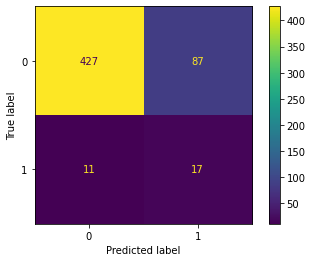

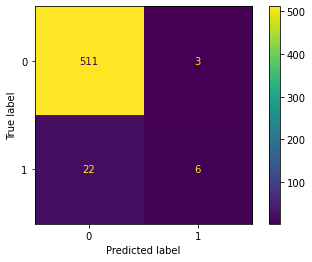

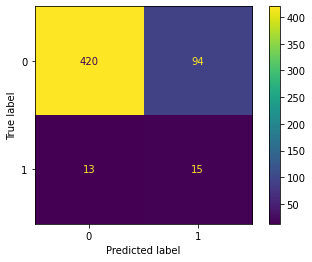

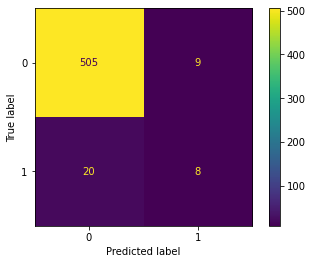

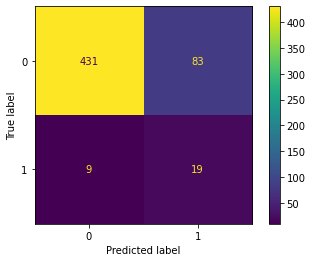

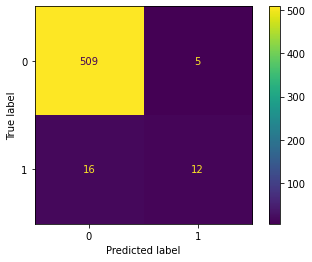

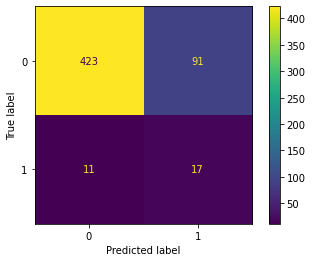

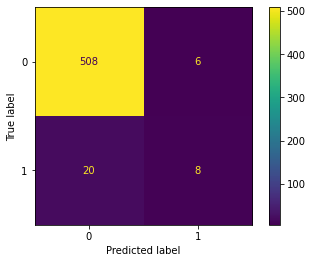

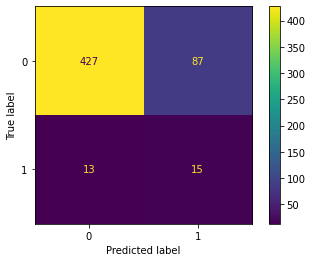

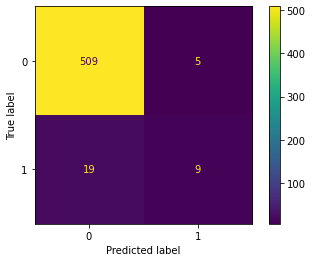

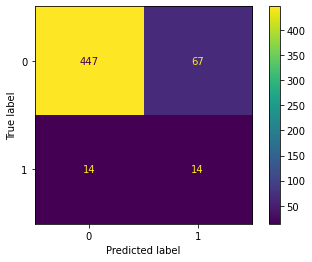

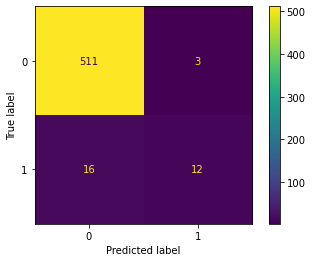

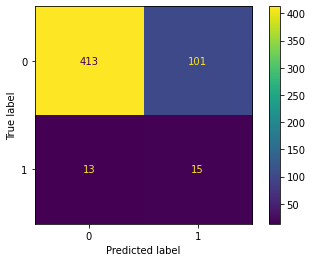

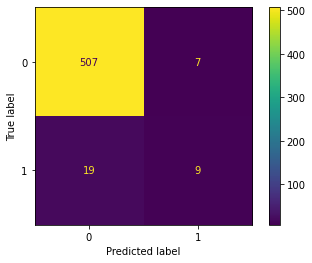

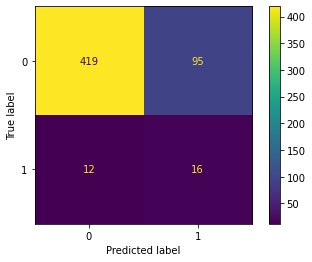

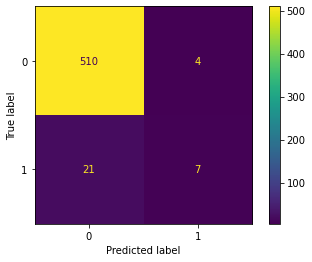

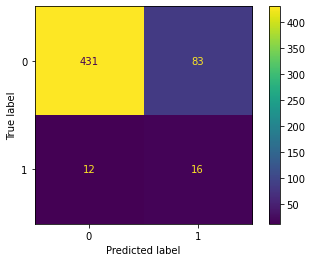

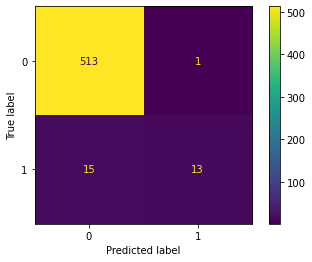

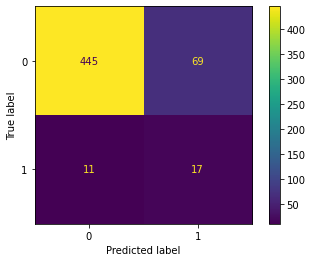

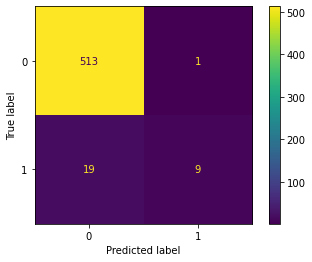

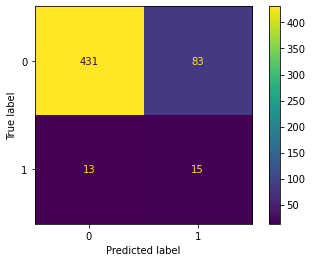

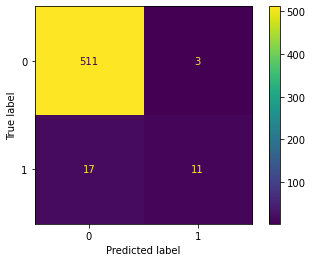

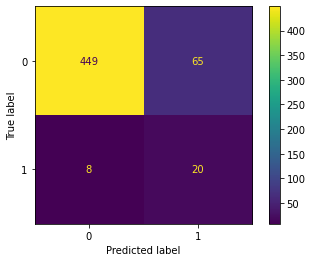

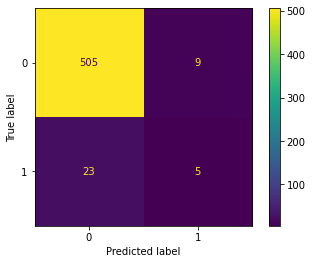

In [64]:
windws = [2]
dimensions = [128,200,500] 
num_walks = [3,5]
walk_length = [50,70]

combinations = list(itertools.product(windws, dimensions, num_walks, walk_length))
binary_f1_scores_lr = []
macro_f1_scores_lr = []
binary_f1_scores_xgb = []
macro_f1_scores_xgb = []
final_combinations = []
times = []

for comb in tqdm(combinations):
    window = comb[0]
    dims = comb[1]
    num_walks = comb[2]
    walk_length = comb[3]
    for _ in range(1):
        try:
            start = time.time()
            deepwalk = DeepWalk(G, window=window, dims=dims, num_walks=num_walks, walk_length=walk_length)
            walks = deepwalk.generate_walks()
            embeddings = deepwalk.skipgram()
            end = time.time()
            duration = end-start
            print("Embedding Time = %s" % (duration))
            binary_f1_lr, macro_f1_lr = predict(G,embeddings, return_f1_score = True, model = 'lr')
            binary_f1_xgb, macro_f1_xgb = predict(G,embeddings, return_f1_score = True, model = 'xgb')
            binary_f1_scores_lr.append(binary_f1_lr)  
            macro_f1_scores_lr.append(macro_f1_lr)
            binary_f1_scores_xgb.append(binary_f1_xgb)  
            macro_f1_scores_xgb.append(macro_f1_xgb)
            final_combinations.append(comb)
            times.append(duration)
        except:
            print('Failed')
            continue

In [65]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1 Logistic Regression"] = binary_f1_scores_lr
df["Test Macro F1 Logistic Regression"] = macro_f1_scores_lr
df["Test Binary F1 XGB"] = binary_f1_scores_xgb
df["Test Macro F1 XGB"] = macro_f1_scores_xgb
df["Duration"] = times # More walks takes a longer time
df.rename(columns = {0: 'Window',
                     1: "Dimension",
                     2: "Number of walks",
                     3: "Walk Length"}, inplace = True)
df = df.sort_values(by=['Test Binary F1 XGB'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(10)

,Window,Dimension,Number of walks,Walk Length,Test Binary F1 Logistic Regression,Test Macro F1 Logistic Regression,Test Binary F1 XGB,Test Macro F1 XGB,Duration
0,2,500,3,50,0.251969,0.576350,0.619048,0.801846,5.173388
1,2,200,3,70,0.256881,0.586902,0.558140,0.769944,6.356327
2,2,128,5,50,0.292308,0.597936,0.533333,0.756561,7.376441
3,2,500,5,50,0.238095,0.568943,0.523810,0.752308,8.421227
4,2,500,3,70,0.298246,0.607886,0.473684,0.727282,7.031882
5,2,200,3,50,0.230769,0.562974,0.428571,0.702769,4.592931
6,2,200,5,50,0.208333,0.543528,0.409091,0.692045,7.530939
7,2,128,5,70,0.250000,0.571203,0.380952,0.678000,10.382065
8,2,200,5,70,0.230216,0.558494,0.358974,0.667525,10.489360
9,2,128,3,70,0.218978,0.552995,0.355556,0.663822,6.229935


  0%|          | 0/1 [00:00<?, ?it/s]

Embedding Time = 5.1212849617004395
Binary test F1: 0.20800000000000002
Macro test F1: 0.5523837330552659


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.5106382978723404
Macro test F1: 0.7442294671618211
Embedding Time = 5.061237812042236
Binary test F1: 0.2702702702702703
Macro test F1: 0.5935112913530181


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.45000000000000007
Macro test F1: 0.714463601532567
Embedding Time = 5.074054002761841
Binary test F1: 0.3275862068965517
Macro test F1: 0.6235038472499288


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.576923076923077
Macro test F1: 0.7778026237328564
Embedding Time = 5.077084064483643
Binary test F1: 0.23853211009174313
Macro test F1: 0.5767019524817689


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.5454545454545454
Macro test F1: 0.7631118881118881
Embedding Time = 5.089630842208862
Binary test F1: 0.31034482758620696
Macro test F1: 0.6138500997435167
Binary test F1: 0.5454545454545454
Macro test F1: 0.7631118881118881
Embedding Time = 5.058315753936768
Binary test F1: 0.2170542635658915
Macro test F1: 0.5556475506311133


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.3333333333333333
Macro test F1: 0.6552162849872774
Embedding Time = 5.064100980758667
Binary test F1: 0.24793388429752067
Macro test F1: 0.5767187593865588


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.6250000000000001
Macro test F1: 0.8038127413127414
Embedding Time = 5.0410239696502686
Binary test F1: 0.2777777777777778
Macro test F1: 0.5989298724954464
Binary test F1: 0.5365853658536585
Macro test F1: 0.759184341603723
Embedding Time = 5.061815977096558
Binary test F1: 0.29090909090909095
Macro test F1: 0.6054134776927385


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Binary test F1: 0.5581395348837209
Macro test F1: 0.7699439269039161
Embedding Time = 5.083485841751099
Binary test F1: 0.32
Macro test F1: 0.6156830031282586


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 1/1 [01:09<00:00, 69.87s/it]

Binary test F1: 0.5365853658536585
Macro test F1: 0.759184341603723


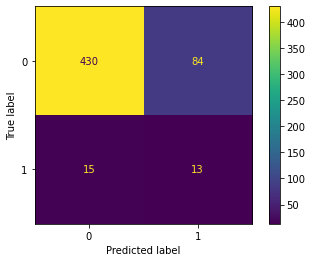

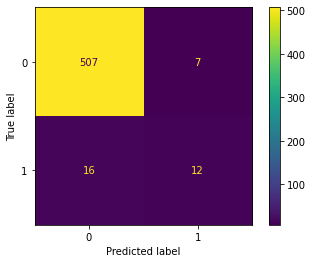

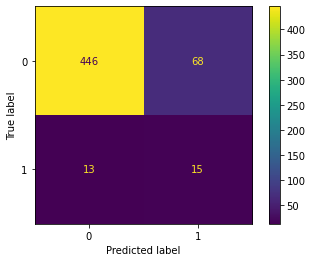

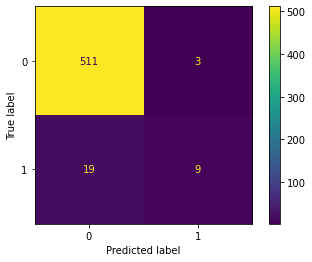

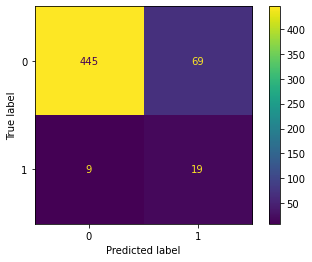

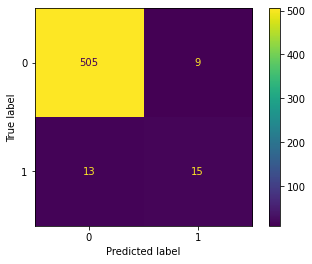

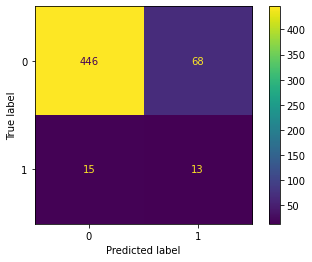

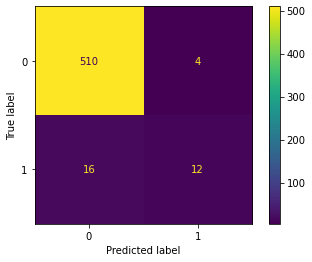

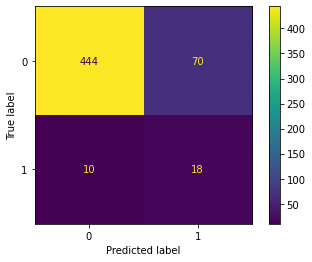

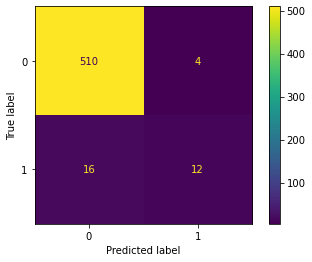

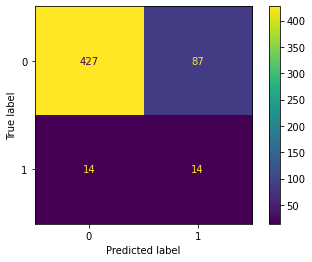

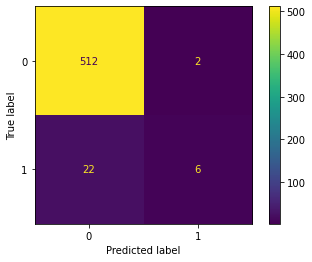

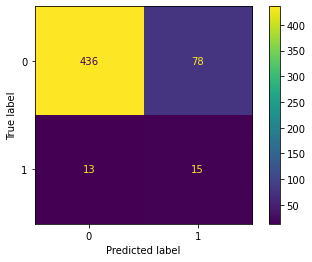

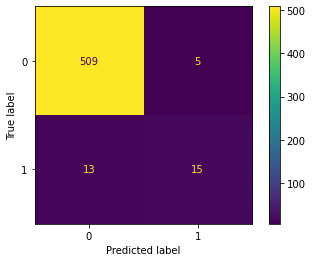

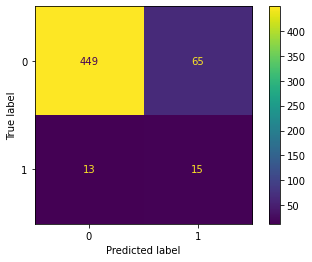

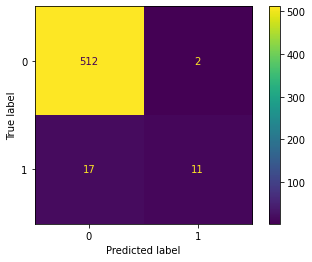

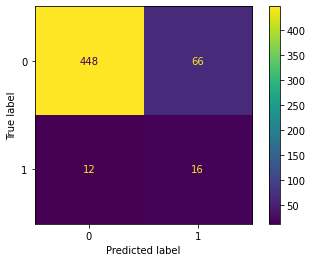

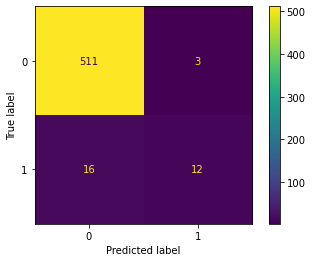

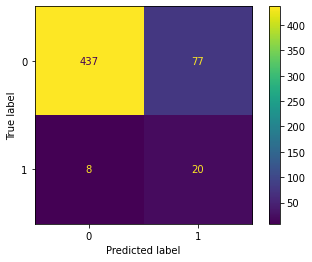

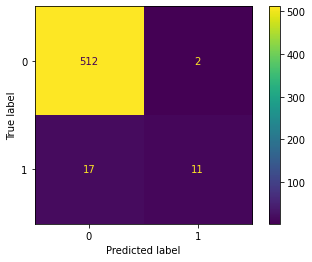

In [67]:
windws = [2]
dimensions = [500] 
num_walks = [3]
walk_length = [50]

combinations = list(itertools.product(windws, dimensions, num_walks, walk_length))
binary_f1_scores_lr = []
macro_f1_scores_lr = []
binary_f1_scores_xgb = []
macro_f1_scores_xgb = []
final_combinations = []
times = []

for comb in tqdm(combinations):
    window = comb[0]
    dims = comb[1]
    num_walks = comb[2]
    walk_length = comb[3]
    for _ in range(10):
        try:
            start = time.time()
            deepwalk = DeepWalk(G, window=window, dims=dims, num_walks=num_walks, walk_length=walk_length)
            walks = deepwalk.generate_walks()
            embeddings = deepwalk.skipgram()
            end = time.time()
            duration = end-start
            print("Embedding Time = %s" % (duration))
            binary_f1_lr, macro_f1_lr = predict(G,embeddings, return_f1_score = True, model = 'lr')
            binary_f1_xgb, macro_f1_xgb = predict(G,embeddings, return_f1_score = True, model = 'xgb')
            binary_f1_scores_lr.append(binary_f1_lr)  
            macro_f1_scores_lr.append(macro_f1_lr)
            binary_f1_scores_xgb.append(binary_f1_xgb)  
            macro_f1_scores_xgb.append(macro_f1_xgb)
            final_combinations.append(comb)
            times.append(duration)
        except:
            print('Failed')
            continue

In [68]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1 Logistic Regression"] = binary_f1_scores_lr
df["Test Macro F1 Logistic Regression"] = macro_f1_scores_lr
df["Test Binary F1 XGB"] = binary_f1_scores_xgb
df["Test Macro F1 XGB"] = macro_f1_scores_xgb
df["Duration"] = times # More walks takes a longer time
df.rename(columns = {0: 'Window',
                     1: "Dimension",
                     2: "Number of walks",
                     3: "Walk Length"}, inplace = True)
df = df.sort_values(by=['Test Binary F1 XGB'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(10)

,Window,Dimension,Number of walks,Walk Length,Test Binary F1 Logistic Regression,Test Macro F1 Logistic Regression,Test Binary F1 XGB,Test Macro F1 XGB,Duration
0,2,500,3,50,0.247934,0.576719,0.625000,0.803813,5.064101
1,2,500,3,50,0.327586,0.623504,0.576923,0.777803,5.074054
2,2,500,3,50,0.290909,0.605413,0.558140,0.769944,5.061816
3,2,500,3,50,0.238532,0.576702,0.545455,0.763112,5.077084
4,2,500,3,50,0.310345,0.613850,0.545455,0.763112,5.089631
5,2,500,3,50,0.277778,0.598930,0.536585,0.759184,5.041024
6,2,500,3,50,0.320000,0.615683,0.536585,0.759184,5.083486
7,2,500,3,50,0.208000,0.552384,0.510638,0.744229,5.121285
8,2,500,3,50,0.270270,0.593511,0.450000,0.714464,5.061238
9,2,500,3,50,0.217054,0.555648,0.333333,0.655216,5.058316


In [69]:
print(f'The mean binary F1 of Deepwalk on XGBoost: {df["Test Binary F1 XGB"].mean()} and the standard deviation: {df["Test Binary F1 XGB"].std()}')
print(f'The mean macro F1 of Deepwalk on XGBoost: {df["Test Macro F1 XGB"].mean()} and the standard deviation: {df["Test Macro F1 XGB"].std()}')
print('-----------------------------')
print(f'The mean binary F1 of Deepwalk on Logistic Regression: {df["Test Binary F1 Logistic Regression"].mean()} and the standard deviation: {df["Test Binary F1 Logistic Regression"].std()}')
print(f'The mean macro F1 of Deepwalk on Logistic Regression: {df["Test Macro F1 Logistic Regression"].mean()} and the standard deviation: {df["Test Macro F1 Logistic Regression"].std()}')
print('-----------------------------')
print(f'The mean duration of the Deepwalk using Word2Vec: {df["Duration"].mean()} and the standard deviation: {df["Duration"].std()}')


The mean binary F1 of Deepwalk on XGBoost: 0.521811406562888 and the standard deviation: 0.07983674402661575
The mean macro F1 of Deepwalk on XGBoost: 0.7510061105062402 and the standard deviation: 0.04061891927668776
-----------------------------
The mean binary F1 of Deepwalk on Logistic Regression: 0.2708408431395053 and the standard deviation: 0.042241311645365834
The mean macro F1 of Deepwalk on Logistic Regression: 0.5912343587217614 and the standard deviation: 0.02497480084301073
-----------------------------
The mean duration of the Deepwalk using Word2Vec: 5.073203420639038 and the standard deviation: 0.021898933504907694


Binary test F1: 0.5128205128205129
Macro test F1: 0.7473193473193473


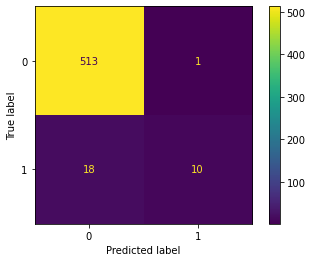

In [70]:
predict(G,embeddings, model = 'xgb')

Embedding Time = 4.673582077026367
TSNE succesfully applied: x now of shape: (2708, 2)


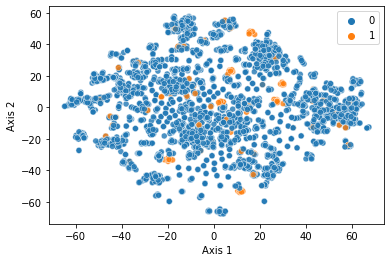

<Figure size 720x720 with 0 Axes>

In [74]:
# Hyperparameters
window = 2
dims = 128
num_walks = 3
walk_length = 50

# Completing DeepWalk embeddings, testing efficiency, and visualizing embeddings in 2-d space
start = time.time()
deepwalk = DeepWalk(G, window=window, dims=dims, num_walks=num_walks, walk_length=walk_length)
walks = deepwalk.generate_walks()
embeddings = deepwalk.skipgram()
end = time.time()
print("Embedding Time = %s" % (end - start))

visualize(G, embeddings, labeled=True)

## Checking whether the fraud dataset works as expected

In [19]:
path = 'inj_cora.pt'
G = read_from_pyg(path)
deepwalk = DeepWalk(G = G, window= 2, dims = 2, num_walks = 3, walk_length = 8)
walks = deepwalk.generate_walks()
data = FraudDataset(walks, 2)
vocab = data.vocab
pairs = data.pairs
print(f'Length of vocab = {len(vocab)}, number of nodes = {len(G.nodes)}')
print(walks[0])
print(pairs[0:5])
len(pairs)

print(data.__getitem__(0)[0].sum())
print(data.__getitem__(0)[1].sum())

Length of vocab = 2708, number of nodes = 2708
[2151, 1224, 778, 1914, 1849, 56, 447, 2638, 447]
[(2151, 1224), (2151, 778), (1224, 2151), (1224, 778), (1224, 1914)]
1.0
1.0


# SkipGram Implementation

Trying to base off this: https://aegis4048.github.io/demystifying_neural_network_in_skip_gram_language_modeling

In [53]:
#################
# TODO 
#################

# 1: Huffman tree
# 2: Negative sampling
# 3: Organization of the classes (?)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SkipGram():
    
    
    
    def __init__(self, dataset, embedding_dims, batch_size, epochs, window_size):
        '''
        dataset: set of random walks, to be used as the corpus
        window_size: window size of the SkipGram
        embedding_dims: output embedding dimensions / NN hidden layer weight matrix dimension
        batch_size: batch size used for training
        epochs: how many epochs to run for training
        '''
        self.embedding_dims = embedding_dims
        self.epochs = epochs
        self.window_size = window_size
        self.data = FraudDataset(dataset, self.window_size)
        self.node_count = self.data.X.shape[1]
        self.batch_size = batch_size

    def fit(self):

        model = Network(self.node_count, self.embedding_dims).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        loss_fcn = nn.BCEWithLogitsLoss()
        data_generator = DataLoader(self.data, batch_size=self.batch_size, shuffle=True)
        model.train()
        losses = []
        for epoch in range(self.epochs):
            for X, y in data_generator:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                logits = model(X)
                loss = loss_fcn(logits, y)
                loss.backward()
                optimizer.step()
                losses.append(loss.item())
            loss_data = np.array(losses).mean()
            print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))
        return model.input_embedding.weight

class Network(nn.Module):
    '''
    random_walks: set of random walks, to be used as the corpus
    node_count: equivalent to the "size of vocab" 
    window_size: window size of the SkipGram
    embedding_dims: output embedding dimensions / NN hidden layer weight matrix dimension
    '''

    def __init__(self, node_count, embedding_dims):
        super(Network, self).__init__()
        self.node_count = node_count
        self.embedding_dims = embedding_dims
        
        ## MAYBE USE max_norm ARGUMENT ##
        self.input_embedding = nn.Embedding(num_embeddings=self.node_count, 
                                            embedding_dim=self.embedding_dims,
                                            max_norm=1)

        # maybe use the initialization we learned in ADL?
        self.input_embedding.weight.data.uniform_(-1, 1)

        self.linear = nn.Linear(in_features=self.embedding_dims,
                                out_features = self.node_count)


    def forward(self, center):
        indices = torch.LongTensor(np.where(center == 1)[1])
        W_input = self.input_embedding(indices)
        y_pred = self.linear(W_input)
        return y_pred

Running the deepwalk model we implemented. To run the original Word2Vec, call deepwalk.deepwalk()

In [40]:
G = read_from_pyg(path)
deepwalk = DeepWalk(G = G, window= 2, dims = 2, num_walks = 3, walk_length = 8)
walks = deepwalk.generate_walks()
model = SkipGram(walks, embedding_dims=2, batch_size=4, epochs=10, window_size=2)
embeddings = model.fit()

Epoch 00001 | Loss: 0.0053
Epoch 00002 | Loss: 0.0041
Epoch 00003 | Loss: 0.0036
Epoch 00004 | Loss: 0.0034
Epoch 00005 | Loss: 0.0033
Epoch 00006 | Loss: 0.0032
Epoch 00007 | Loss: 0.0031
Epoch 00008 | Loss: 0.0031
Epoch 00009 | Loss: 0.0030
Epoch 00010 | Loss: 0.0030


In [41]:
# So far, prediction with these embeddings is weak, but also very low dimension compared to 
# what was run before due to computing constraints.

predict(G, embeddings.detach().numpy())

0.4833948339483395
[[0.47276265 0.52723735]
 [0.32142857 0.67857143]]


# Running benchmark Models

In this section, we will run different models for node classification on the fraud detection dataset. As such, we hope to compare the DeepWalk method with these other models. 

We start by loading in the correct graph. We use a dataset from the PyGod team, they maintain a library for Graph Outlier Detection. Our goal here is to detect these outliers. 

In [3]:
from pygod.utils import load_data
data = load_data('inj_cora')
data.y = data.y.bool()

Our goal is outlier detection, from the github: 

0: inlier
1: contextual outlier only
2: structural outlier only
3: both contextual outlier and structural outlier

So 1,2,3 are all outliers

In [4]:
x = data.x # tensor of shape (2708,1433). All rows sum to one (all features for a specific node)
y = data.y # 138 nodes have label 1
y[np.where(y == 2)] = 1
y[np.where(y == 3)] = 1
edge_index = data.edge_index # tensor of shape (2,11060). Each column contains (source,target) for an edge

Some loss functions need a 2D loss, these operations take care of that (not needed for cross entropy loss)

In [11]:
dataset_indices = torch.arange(len(y))
zeros = torch.from_numpy(np.where(y ==0)[0])
ones = torch.from_numpy(np.where(y ==1)[0])
zeros = torch.isin(dataset_indices, zeros)
ones = torch.isin(dataset_indices, ones)
targets = torch.stack([zeros,ones], dim = 1)
targets = targets.type(torch.float64)

## Graph Neural Networks

In [18]:
class GCN(torch.nn.Module):
    
    def __init__(self,input_channels,hidden_channels,output_channels):
        super().__init__()
        self.gcnconv1 = GCNConv(input_channels, hidden_channels)
        self.gcnconv2 = GCNConv(hidden_channels,hidden_channels)
        self.gcnconv3 = GCNConv(hidden_channels,output_channels)
        
        self.relu = torch.nn.ReLU()
        
    def forward(self, x,edge_index):
        # no dropout so far
        x = self.relu(self.gcnconv1(x,edge_index))
        x = self.relu(self.gcnconv2(x,edge_index))
        x = F.dropout(x, p=0.2)
        x = self.gcnconv3(x,edge_index)
        return x

In [12]:
import torch_geometric.nn as graphnn


class GAT(nn.Module):
      def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
      
        self.gat1 = graphnn.GATv2Conv(input_size, hidden_size, heads = 4)
        self.lin1 = torch.nn.Linear(input_size, 4 * hidden_size)
        self.gat2 = graphnn.GATv2Conv(hidden_size*4, hidden_size, heads = 4)
        self.lin2 = torch.nn.Linear(4 * hidden_size, 4*hidden_size)
        self.gat3 = graphnn.GATv2Conv(hidden_size*4, output_size, heads = 6, concat = False)
        self.lin3 = torch.nn.Linear(4 * hidden_size, output_size)
        self.dropout = nn.Dropout()
        self.elu = nn.ELU()

      
      def forward(self, x, edge_index):
        x1 = self.gat1(x, edge_index) + self.lin1(x)
        x1 = self.elu(x1)
        x2 = self.gat2(x1, edge_index) + self.lin2(x1)
        x2 = self.elu(x2)
        x2 = F.dropout(x2,p=0.5)
        x3 = self.gat3(x2, edge_index) + (self.lin3(x2))
        return x3

We use a train_test split from the helper function. In this function, I aim to keep the test set the same as for our benchmarking of deepwalk.

In [9]:
def train_val_test_split(data, train_indices, test_indices):
    # dataset size
    N = len(data.y)
    # we also want a validation set of 10%
    val_size = math.floor(N/10)
    print(val_size)
    
    val_indices = np.random.choice(train_indices,size = val_size, replace = False)
    train_indices = np.sort(np.setdiff1d(train_indices,val_indices))
    # obtain all indices in the dataset
    dataset_indices = torch.arange(N)
    train_mask = torch.isin(dataset_indices,torch.from_numpy(train_indices))
    val_mask = torch.isin(dataset_indices,torch.from_numpy(val_indices))
    test_mask = torch.isin(dataset_indices,torch.from_numpy(test_indices))
    
    return train_mask, val_mask, test_mask
    
# Split the data based on the train_test split made for the deepwalk benchmark
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)
train_mask, val_mask, test_mask = train_val_test_split(data, np.sort(np.array(y_train.index)),np.sort(np.array(y_test.index)))

270


In [14]:
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

def train(model, edge_index, x, labels, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask):
    best_val_f1 = 0
    model.train()

    
    for epoch in range(num_epochs):
        # Forward pass for all nodes
        pred = model(x, edge_index)
        # Compute loss on training set
        train_loss = criterion(pred[train_mask].type(torch.float64), labels[train_mask].type(torch.long))
        val_loss = criterion(pred[val_mask].type(torch.float64), labels[val_mask].type(torch.long))
        # Compute accuracy on training/validation/test
        pred = torch.argmax(pred, dim=1)
        train_f1 = f1_score(labels[train_mask].numpy(),pred[train_mask].numpy(), average = 'binary')
        val_f1 = f1_score(labels[val_mask].numpy(),pred[val_mask].numpy(), average = 'binary')
        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_f1 < val_f1:
            best_val_f1 = val_f1

        # Backward
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()

        if epoch % 100 == 0:
            print('Epoch {}: train loss {:.3f}, val loss {:.3f} ,train F1: {:.3f}, val F1: {:.3f}'.format(
                epoch, train_loss, val_loss,train_f1, val_f1))
            print(f'The number of outliers predicted: {sum(pred)}')

    

def test(model, edge_index, x, labels, test_mask):
    model.eval()
    out = model(x, edge_index)
    # make this F1-score
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    binary_f1 = f1_score(labels[test_mask].numpy(),pred[test_mask].numpy(), average = 'binary')
    macro_f1 = f1_score(labels[test_mask].numpy(),pred[test_mask].numpy(), average = 'macro')
    print(f'Test accuracy: {test_acc} and test binary F1: {binary_f1}, test macro: {macro_f1}')
    #print(confusion_matrix(labels[val_mask].numpy(),pred[val_mask].numpy(), normalize = 'true'))
    #print(confusion_matrix(labels[val_mask].numpy(),pred[val_mask].numpy()))
    disp = ConfusionMatrixDisplay(confusion_matrix(labels[test_mask].numpy(),pred[test_mask].numpy()))
    disp.plot()
    return binary_f1, macro_f1

### GAT Architecture

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0: train loss 0.741, val loss 0.713 ,train F1: 0.093, val F1: 0.162
The number of outliers predicted: 2467
Epoch 100: train loss 0.004, val loss 3.089 ,train F1: 1.000, val F1: 0.550
The number of outliers predicted: 142
Epoch 200: train loss 0.002, val loss 3.060 ,train F1: 1.000, val F1: 0.537
The number of outliers predicted: 141
Epoch 300: train loss 0.026, val loss 1.700 ,train F1: 0.939, val F1: 0.579
The number of outliers predicted: 147
Epoch 400: train loss 0.003, val loss 2.957 ,train F1: 1.000, val F1: 0.541
The number of outliers predicted: 135
Epoch 500: train loss 0.002, val loss 2.548 ,train F1: 1.000, val F1: 0.457
The number of outliers predicted: 129
Epoch 600: train loss 0.002, val loss 2.938 ,train F1: 1.000, val F1: 0.500
The number of outliers predicted: 130
Epoch 700: train loss 0.003, val loss 3.035 ,train F1: 1.000, val F1: 0.500
The number of outliers predicted: 130
Epoch 800: train loss 0.002, val loss 2.741 ,train F1: 1.000, val F1: 0.500
The number of

 33%|███▎      | 1/3 [00:54<01:49, 54.94s/it]

Test accuracy: 0.967 and test binary F1: 0.9473684210526316, test macro: 0.9722236457746118
Epoch 0: train loss 0.658, val loss 0.686 ,train F1: 0.082, val F1: 0.122
The number of outliers predicted: 289
Epoch 100: train loss 0.003, val loss 2.826 ,train F1: 0.995, val F1: 0.512
The number of outliers predicted: 148
Epoch 200: train loss 0.002, val loss 3.722 ,train F1: 1.000, val F1: 0.486
The number of outliers predicted: 138
Epoch 300: train loss 0.003, val loss 2.570 ,train F1: 1.000, val F1: 0.457
The number of outliers predicted: 128
Epoch 400: train loss 0.002, val loss 3.071 ,train F1: 1.000, val F1: 0.412
The number of outliers predicted: 129
Epoch 500: train loss 0.002, val loss 2.599 ,train F1: 1.000, val F1: 0.471
The number of outliers predicted: 129
Epoch 600: train loss 0.002, val loss 2.736 ,train F1: 1.000, val F1: 0.471
The number of outliers predicted: 128
Epoch 700: train loss 0.002, val loss 2.910 ,train F1: 1.000, val F1: 0.471
The number of outliers predicted: 12

 67%|██████▋   | 2/3 [02:07<01:05, 65.22s/it]

Test accuracy: 0.96 and test binary F1: 0.9473684210526316, test macro: 0.9722236457746118
Epoch 0: train loss 0.728, val loss 0.712 ,train F1: 0.090, val F1: 0.125
The number of outliers predicted: 2502
Epoch 100: train loss 0.001, val loss 3.175 ,train F1: 1.000, val F1: 0.550
The number of outliers predicted: 140
Epoch 200: train loss 0.005, val loss 2.945 ,train F1: 0.995, val F1: 0.364
The number of outliers predicted: 126
Epoch 300: train loss 0.002, val loss 3.358 ,train F1: 1.000, val F1: 0.500
The number of outliers predicted: 131
Epoch 400: train loss 0.002, val loss 3.453 ,train F1: 1.000, val F1: 0.500
The number of outliers predicted: 135
Epoch 500: train loss 0.001, val loss 3.233 ,train F1: 1.000, val F1: 0.541
The number of outliers predicted: 135
Epoch 600: train loss 0.001, val loss 3.614 ,train F1: 1.000, val F1: 0.541
The number of outliers predicted: 134
Epoch 700: train loss 0.002, val loss 3.610 ,train F1: 1.000, val F1: 0.500
The number of outliers predicted: 13

100%|██████████| 3/3 [03:39<00:00, 73.26s/it]

Test accuracy: 0.961 and test binary F1: 0.9473684210526316, test macro: 0.9722236457746118


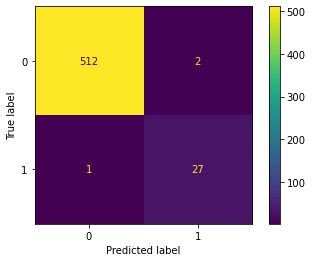

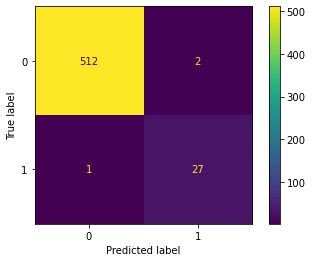

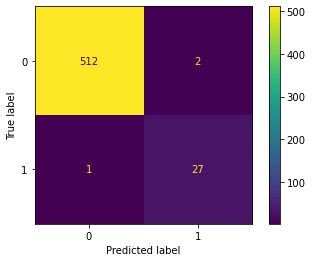

In [15]:
hidden_size = [4,8,16]
lr = [0.01]
weight_decay = [0.00005]
class_weight = [np.array([0.1,0.8])]

combinations = list(itertools.product(hidden_size, lr, weight_decay, class_weight))
binary_f1_scores = []
macro_f1_scores = []
final_combinations = []

for comb in tqdm(combinations):
    for _ in range(1):
        hidden_size = comb[0]
        lr = comb[1]
        weight_decay = comb[2]
        class_weight = comb[3]
        try:
            model = GAT(x.shape[1], hidden_size,2)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
            criterion = torch.nn.CrossEntropyLoss(weight = torch.from_numpy(class_weight))
            num_epochs = 1000
            train(model, edge_index, x, y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask)                                     

            
            binary_f1, macro_f1 = test(model, edge_index, x, y, test_mask)
            binary_f1_scores.append(binary_f1)  
            macro_f1_scores.append(macro_f1)
            final_combinations.append(comb)
        except:
            continue

In [16]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1"] = binary_f1_scores
df["Test Macro F1"] = macro_f1_scores
df.rename(columns = {0: 'Hidden_size',
                     1: "Learning rate",
                     2: "Weight decay",
                     3: "Class Weight"}, inplace = True)
df = df.sort_values(by=['Test Binary F1'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(3)

,Hidden_size,Learning rate,Weight decay,Class Weight,Test Binary F1,Test Macro F1
0,4,0.01,0.00005,"[0.1, 0.8]",0.947368,0.972224
1,8,0.01,0.00005,"[0.1, 0.8]",0.947368,0.972224
2,16,0.01,0.00005,"[0.1, 0.8]",0.947368,0.972224


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: train loss 0.716, val loss 0.700 ,train F1: 0.094, val F1: 0.160
The number of outliers predicted: 1926
Epoch 100: train loss 0.004, val loss 2.847 ,train F1: 1.000, val F1: 0.564
The number of outliers predicted: 135
Epoch 200: train loss 0.002, val loss 2.766 ,train F1: 1.000, val F1: 0.585
The number of outliers predicted: 147
Epoch 300: train loss 0.001, val loss 3.159 ,train F1: 0.995, val F1: 0.579
The number of outliers predicted: 136
Epoch 400: train loss 0.001, val loss 3.188 ,train F1: 1.000, val F1: 0.541
The number of outliers predicted: 135
Epoch 500: train loss 0.001, val loss 3.273 ,train F1: 1.000, val F1: 0.500
The number of outliers predicted: 133
Epoch 600: train loss 0.002, val loss 2.894 ,train F1: 0.995, val F1: 0.579
The number of outliers predicted: 136
Epoch 700: train loss 0.001, val loss 3.122 ,train F1: 1.000, val F1: 0.526
The number of outliers predicted: 136
Epoch 800: train loss 0.001, val loss 3.543 ,train F1: 1.000, val F1: 0.526
The number of

Epoch 800: train loss 0.002, val loss 2.814 ,train F1: 1.000, val F1: 0.541
The number of outliers predicted: 131
Epoch 900: train loss 0.001, val loss 2.414 ,train F1: 1.000, val F1: 0.500
The number of outliers predicted: 132
Test accuracy: 0.964 and test binary F1: 0.9285714285714286, test macro: 0.9623401889938855
Epoch 0: train loss 0.831, val loss 0.768 ,train F1: 0.093, val F1: 0.158
The number of outliers predicted: 2705
Epoch 100: train loss 0.003, val loss 2.173 ,train F1: 1.000, val F1: 0.537
The number of outliers predicted: 143
Epoch 200: train loss 0.002, val loss 2.675 ,train F1: 1.000, val F1: 0.500
The number of outliers predicted: 139
Epoch 300: train loss 0.002, val loss 2.718 ,train F1: 1.000, val F1: 0.526
The number of outliers predicted: 134
Epoch 400: train loss 0.004, val loss 2.135 ,train F1: 0.995, val F1: 0.556
The number of outliers predicted: 132
Epoch 500: train loss 0.003, val loss 2.604 ,train F1: 0.995, val F1: 0.556
The number of outliers predicted: 1

100%|██████████| 1/1 [09:36<00:00, 576.59s/it]

Test accuracy: 0.965 and test binary F1: 0.9473684210526316, test macro: 0.9722236457746118


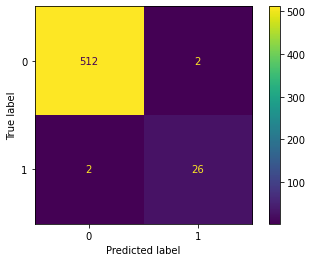

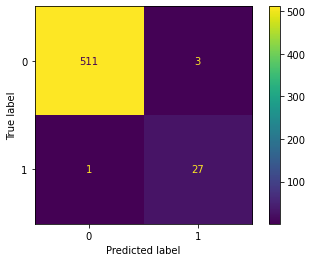

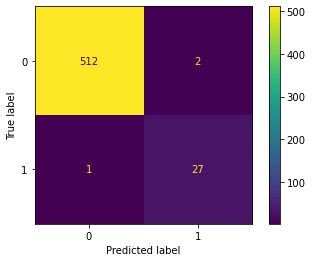

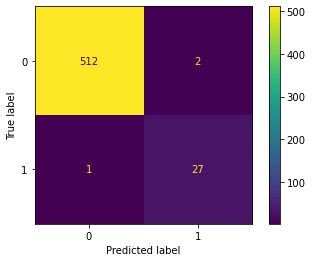

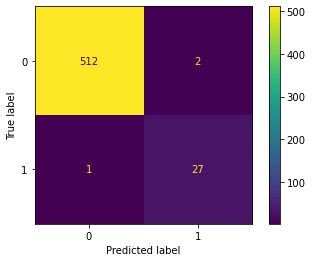

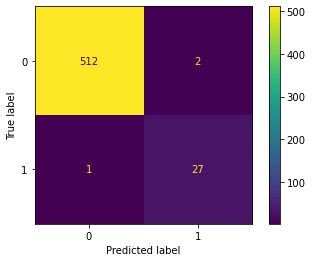

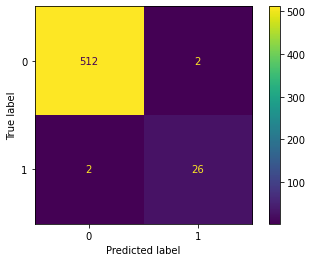

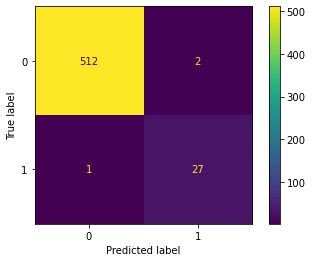

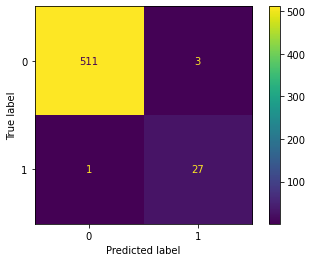

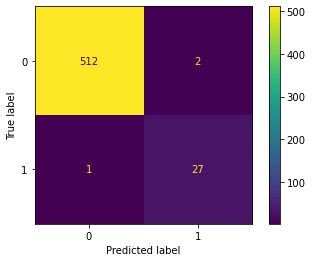

In [17]:
hidden_size = [4]
lr = [0.01]
weight_decay = [0.00005]
class_weight = [np.array([0.1,0.8])]

combinations = list(itertools.product(hidden_size, lr, weight_decay, class_weight))
binary_f1_scores = []
macro_f1_scores = []
final_combinations = []

for comb in tqdm(combinations):
    for _ in range(10):
        hidden_size = comb[0]
        lr = comb[1]
        weight_decay = comb[2]
        class_weight = comb[3]
        try:
            model = GAT(x.shape[1], hidden_size,2)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
            criterion = torch.nn.CrossEntropyLoss(weight = torch.from_numpy(class_weight))
            num_epochs = 1000
            train(model, edge_index, x, y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask)                                     

            
            binary_f1, macro_f1 = test(model, edge_index, x, y, test_mask)
            binary_f1_scores.append(binary_f1)  
            macro_f1_scores.append(macro_f1)
            final_combinations.append(comb)
        except:
            continue

In [18]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1"] = binary_f1_scores
df["Test Macro F1"] = macro_f1_scores
df.rename(columns = {0: 'Hidden_size',
                     1: "Learning rate",
                     2: "Weight decay",
                     3: "Class Weight"}, inplace = True)
df = df.sort_values(by=['Test Binary F1'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(8)

,Hidden_size,Learning rate,Weight decay,Class Weight,Test Binary F1,Test Macro F1
0,4,0.01,0.00005,"[0.1, 0.8]",0.947368,0.972224
1,4,0.01,0.00005,"[0.1, 0.8]",0.947368,0.972224
2,4,0.01,0.00005,"[0.1, 0.8]",0.947368,0.972224
3,4,0.01,0.00005,"[0.1, 0.8]",0.947368,0.972224
4,4,0.01,0.00005,"[0.1, 0.8]",0.947368,0.972224
5,4,0.01,0.00005,"[0.1, 0.8]",0.947368,0.972224
6,4,0.01,0.00005,"[0.1, 0.8]",0.931034,0.963568
7,4,0.01,0.00005,"[0.1, 0.8]",0.931034,0.963568


In [19]:
print(f'The mean binary F1 of GAT: {df["Test Binary F1"].mean()} and the standard deviation: {df["Test Binary F1"].std()}')
print(f'The mean macro F1 of GAT: {df["Test Macro F1"].mean()} and the standard deviation: {df["Test Macro F1"].std()}')

The mean binary F1 of GAT: 0.940342234897589 and the standard deviation: 0.009107847740692709
The mean macro F1 of GAT: 0.9685158099916478 and the standard deviation: 0.004804257663364302


### GCN Architecture

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch 0: train loss 0.693, val loss 0.693 ,train F1: 0.077, val F1: 0.045
The number of outliers predicted: 824
Epoch 100: train loss 0.617, val loss 0.609 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 200: train loss 0.573, val loss 0.553 ,train F1: 0.301, val F1: 0.324
The number of outliers predicted: 418
Epoch 300: train loss 0.326, val loss 0.393 ,train F1: 0.640, val F1: 0.600
The number of outliers predicted: 168
Epoch 400: train loss 0.305, val loss 0.387 ,train F1: 0.667, val F1: 0.621
The number of outliers predicted: 193
Epoch 500: train loss 0.302, val loss 0.379 ,train F1: 0.698, val F1: 0.621
The number of outliers predicted: 163
Epoch 600: train loss 0.300, val loss 0.370 ,train F1: 0.685, val F1: 0.621
The number of outliers predicted: 169
Epoch 700: train loss 0.295, val loss 0.385 ,train F1: 0.676, val F1: 0.643
The number of outliers predicted: 167
Epoch 800: train loss 0.298, val loss 0.379 ,train F1: 0.684, val F1: 0.600
The number of ou

 12%|█▎        | 1/8 [00:43<05:04, 43.44s/it]

Test accuracy: 0.947 and test binary F1: 0.6857142857142857, test macro: 0.8320090166244012
Epoch 0: train loss 0.693, val loss 0.693 ,train F1: 0.076, val F1: 0.054
The number of outliers predicted: 940
Epoch 100: train loss 0.634, val loss 0.624 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 4
Epoch 200: train loss 0.470, val loss 0.483 ,train F1: 0.545, val F1: 0.516
The number of outliers predicted: 145
Epoch 300: train loss 0.313, val loss 0.412 ,train F1: 0.688, val F1: 0.643
The number of outliers predicted: 162
Epoch 400: train loss 0.312, val loss 0.398 ,train F1: 0.547, val F1: 0.357
The number of outliers predicted: 317
Epoch 500: train loss 0.301, val loss 0.389 ,train F1: 0.652, val F1: 0.643
The number of outliers predicted: 189
Epoch 600: train loss 0.299, val loss 0.385 ,train F1: 0.681, val F1: 0.667
The number of outliers predicted: 191
Epoch 700: train loss 0.293, val loss 0.388 ,train F1: 0.678, val F1: 0.621
The number of outliers predicted: 196


 25%|██▌       | 2/8 [01:24<04:13, 42.19s/it]

Test accuracy: 0.938 and test binary F1: 0.6486486486486486, test macro: 0.8114530371956115
Epoch 0: train loss 0.693, val loss 0.693 ,train F1: 0.099, val F1: 0.135
The number of outliers predicted: 765
Epoch 100: train loss 0.177, val loss 0.611 ,train F1: 0.649, val F1: 0.346
The number of outliers predicted: 335
Epoch 200: train loss 0.167, val loss 0.650 ,train F1: 0.583, val F1: 0.316
The number of outliers predicted: 395
Epoch 300: train loss 0.123, val loss 0.872 ,train F1: 0.761, val F1: 0.409
The number of outliers predicted: 264
Epoch 400: train loss 0.086, val loss 1.017 ,train F1: 0.844, val F1: 0.450
The number of outliers predicted: 236
Epoch 500: train loss 0.084, val loss 1.033 ,train F1: 0.851, val F1: 0.429
The number of outliers predicted: 240
Epoch 600: train loss 0.081, val loss 1.003 ,train F1: 0.838, val F1: 0.429
The number of outliers predicted: 247
Epoch 700: train loss 0.077, val loss 1.040 ,train F1: 0.842, val F1: 0.429
The number of outliers predicted: 23

 38%|███▊      | 3/8 [02:07<03:32, 42.53s/it]

Test accuracy: 0.911 and test binary F1: 0.8484848484848484, test macro: 0.9193308328868249
Epoch 0: train loss 0.693, val loss 0.693 ,train F1: 0.106, val F1: 0.115
The number of outliers predicted: 840
Epoch 100: train loss 0.106, val loss 0.827 ,train F1: 0.760, val F1: 0.429
The number of outliers predicted: 271
Epoch 200: train loss 0.090, val loss 0.910 ,train F1: 0.821, val F1: 0.462
The number of outliers predicted: 237
Epoch 300: train loss 0.088, val loss 0.969 ,train F1: 0.724, val F1: 0.360
The number of outliers predicted: 292
Epoch 400: train loss 0.072, val loss 0.972 ,train F1: 0.821, val F1: 0.474
The number of outliers predicted: 236
Epoch 500: train loss 0.073, val loss 1.054 ,train F1: 0.856, val F1: 0.400
The number of outliers predicted: 231
Epoch 600: train loss 0.070, val loss 1.029 ,train F1: 0.867, val F1: 0.439
The number of outliers predicted: 225
Epoch 700: train loss 0.066, val loss 1.012 ,train F1: 0.838, val F1: 0.450
The number of outliers predicted: 23

 50%|█████     | 4/8 [02:51<02:52, 43.18s/it]

Test accuracy: 0.923 and test binary F1: 0.8235294117647058, test macro: 0.9058591940713292
Epoch 0: train loss 0.694, val loss 0.694 ,train F1: 0.104, val F1: 0.100
The number of outliers predicted: 2626
Epoch 100: train loss 0.634, val loss 0.645 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 200: train loss 0.631, val loss 0.641 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 300: train loss 0.628, val loss 0.635 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 400: train loss 0.626, val loss 0.629 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 500: train loss 0.625, val loss 0.628 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 600: train loss 0.626, val loss 0.628 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 700: train loss 0.625, val loss 0.628 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 800: 

 62%|██████▎   | 5/8 [03:36<02:10, 43.65s/it]

Test accuracy: 0.954 and test binary F1: 0.0, test macro: 0.48674242424242425
Epoch 0: train loss 0.694, val loss 0.694 ,train F1: 0.102, val F1: 0.102
The number of outliers predicted: 2623
Epoch 100: train loss 0.650, val loss 0.659 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 200: train loss 0.646, val loss 0.653 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 300: train loss 0.644, val loss 0.648 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 400: train loss 0.642, val loss 0.642 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 500: train loss 0.642, val loss 0.642 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 600: train loss 0.641, val loss 0.641 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 700: train loss 0.641, val loss 0.640 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 800: train loss 0.6

 75%|███████▌  | 6/8 [04:23<01:29, 44.93s/it]

Test accuracy: 0.954 and test binary F1: 0.0, test macro: 0.48674242424242425
Epoch 0: train loss 0.694, val loss 0.694 ,train F1: 0.101, val F1: 0.099
The number of outliers predicted: 2676
Epoch 100: train loss 0.449, val loss 0.572 ,train F1: 0.000, val F1: 0.000
The number of outliers predicted: 0
Epoch 200: train loss 0.151, val loss 0.588 ,train F1: 0.725, val F1: 0.462
The number of outliers predicted: 263
Epoch 300: train loss 0.102, val loss 0.703 ,train F1: 0.802, val F1: 0.439
The number of outliers predicted: 251
Epoch 400: train loss 0.087, val loss 0.766 ,train F1: 0.828, val F1: 0.450
The number of outliers predicted: 237
Epoch 500: train loss 0.088, val loss 0.819 ,train F1: 0.828, val F1: 0.474
The number of outliers predicted: 233
Epoch 600: train loss 0.087, val loss 0.804 ,train F1: 0.838, val F1: 0.474
The number of outliers predicted: 230
Epoch 700: train loss 0.083, val loss 0.815 ,train F1: 0.845, val F1: 0.474
The number of outliers predicted: 228
Epoch 800: tr

 88%|████████▊ | 7/8 [05:08<00:44, 44.93s/it]

Test accuracy: 0.916 and test binary F1: 0.7887323943661972, test macro: 0.8869624459491401
Epoch 0: train loss 0.693, val loss 0.693 ,train F1: 0.073, val F1: 0.064
The number of outliers predicted: 1357
Epoch 100: train loss 0.412, val loss 0.590 ,train F1: 0.400, val F1: 0.000
The number of outliers predicted: 133
Epoch 200: train loss 0.132, val loss 0.634 ,train F1: 0.769, val F1: 0.439
The number of outliers predicted: 255
Epoch 300: train loss 0.099, val loss 0.757 ,train F1: 0.786, val F1: 0.450
The number of outliers predicted: 253
Epoch 400: train loss 0.087, val loss 0.862 ,train F1: 0.849, val F1: 0.474
The number of outliers predicted: 223
Epoch 500: train loss 0.086, val loss 0.826 ,train F1: 0.831, val F1: 0.450
The number of outliers predicted: 233
Epoch 600: train loss 0.084, val loss 0.848 ,train F1: 0.838, val F1: 0.474
The number of outliers predicted: 230
Epoch 700: train loss 0.085, val loss 0.842 ,train F1: 0.828, val F1: 0.450
The number of outliers predicted: 2

100%|██████████| 8/8 [05:54<00:00, 44.30s/it]

Test accuracy: 0.92 and test binary F1: 0.8235294117647058, test macro: 0.9058591940713292


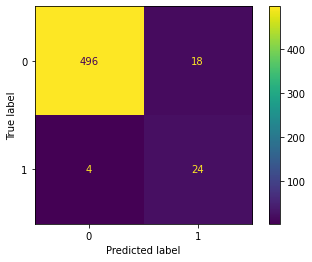

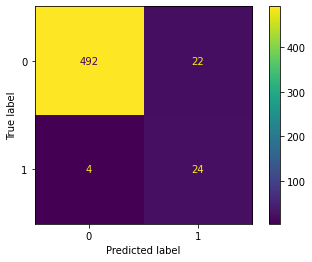

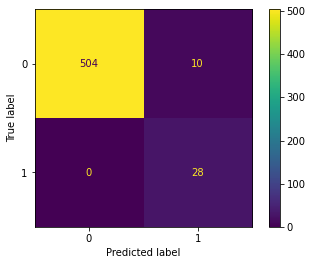

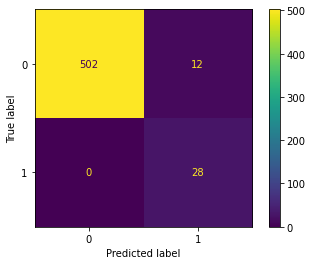

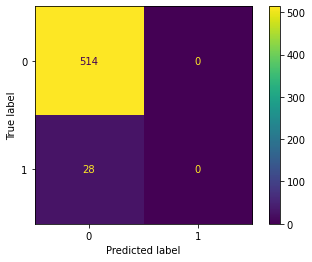

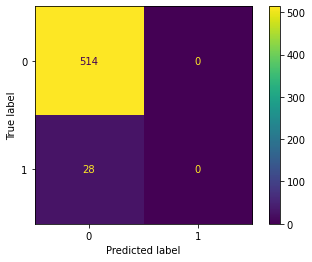

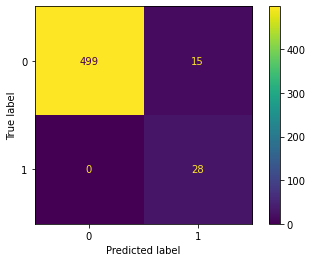

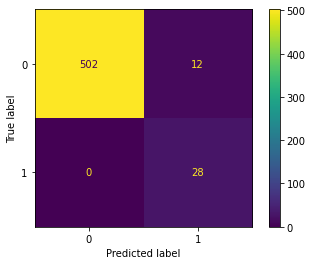

In [29]:
hidden_size = [128]
lr = [0.01, 0.001]
weight_decay = [5e-3, 5e-4]
class_weight = [np.array([0.1,0.8]), np.array([0.1,0.9])]

combinations = list(itertools.product(hidden_size, lr, weight_decay, class_weight))
binary_f1_scores = []
macro_f1_scores = []
final_combinations = []

for comb in tqdm(combinations):
    for _ in range(1):
        hidden_size = comb[0]
        lr = comb[1]
        weight_decay = comb[2]
        class_weight = comb[3]
        try:
            model = GCN(x.shape[1], hidden_size,2)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
            criterion = torch.nn.CrossEntropyLoss(weight = torch.from_numpy(class_weight))
            num_epochs = 1000
            train(model, edge_index, x, y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask)                                     

            
            binary_f1, macro_f1 = test(model, edge_index, x, y, test_mask)
            binary_f1_scores.append(binary_f1)  
            macro_f1_scores.append(macro_f1)
            final_combinations.append(comb)
        except:
            continue
        
        
#model = GCN(x.shape[1], 128, 2)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)

#criterion = torch.nn.CrossEntropyLoss(weight = torch.from_numpy(np.array([0.1,0.8])))
#num_epochs = 1000

#train(model, edge_index, x, y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask)

In [30]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1"] = binary_f1_scores
df["Test Macro F1"] = macro_f1_scores
df.rename(columns = {0: 'Hidden_size',
                     1: "Learning rate",
                     2: "Weight decay",
                     3: "Class Weight"}, inplace = True)
df = df.sort_values(by=['Test Binary F1'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(8)

,Hidden_size,Learning rate,Weight decay,Class Weight,Test Binary F1,Test Macro F1
0,128,0.010,0.0005,"[0.1, 0.8]",0.848485,0.919331
1,128,0.010,0.0005,"[0.1, 0.9]",0.823529,0.905859
2,128,0.001,0.0005,"[0.1, 0.9]",0.823529,0.905859
3,128,0.001,0.0005,"[0.1, 0.8]",0.788732,0.886962
4,128,0.010,0.0050,"[0.1, 0.8]",0.685714,0.832009
5,128,0.010,0.0050,"[0.1, 0.9]",0.648649,0.811453
6,128,0.001,0.0050,"[0.1, 0.8]",0.000000,0.486742
7,128,0.001,0.0050,"[0.1, 0.9]",0.000000,0.486742


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0: train loss 0.695, val loss 0.695 ,train F1: 0.100, val F1: 0.099
The number of outliers predicted: 2698
Epoch 100: train loss 0.141, val loss 0.686 ,train F1: 0.725, val F1: 0.409
The number of outliers predicted: 271
Epoch 200: train loss 0.096, val loss 0.860 ,train F1: 0.820, val F1: 0.462
The number of outliers predicted: 229
Epoch 300: train loss 0.222, val loss 1.427 ,train F1: 0.717, val F1: 0.533
The number of outliers predicted: 132
Epoch 400: train loss 0.075, val loss 0.975 ,train F1: 0.830, val F1: 0.450
The number of outliers predicted: 230
Epoch 500: train loss 0.075, val loss 0.910 ,train F1: 0.849, val F1: 0.486
The number of outliers predicted: 225
Epoch 600: train loss 0.074, val loss 0.935 ,train F1: 0.842, val F1: 0.409
The number of outliers predicted: 238
Epoch 700: train loss 0.070, val loss 0.957 ,train F1: 0.874, val F1: 0.439
The number of outliers predicted: 218
Epoch 800: train loss 0.068, val loss 0.943 ,train F1: 0.867, val F1: 0.474
The number of

Epoch 800: train loss 0.068, val loss 0.962 ,train F1: 0.852, val F1: 0.429
The number of outliers predicted: 232
Epoch 900: train loss 0.070, val loss 0.969 ,train F1: 0.863, val F1: 0.462
The number of outliers predicted: 221
Test accuracy: 0.927 and test binary F1: 0.7887323943661972, test macro: 0.8869624459491401
Epoch 0: train loss 0.693, val loss 0.693 ,train F1: 0.081, val F1: 0.086
The number of outliers predicted: 1732
Epoch 100: train loss 0.157, val loss 0.713 ,train F1: 0.767, val F1: 0.439
The number of outliers predicted: 253
Epoch 200: train loss 0.123, val loss 0.938 ,train F1: 0.798, val F1: 0.450
The number of outliers predicted: 234
Epoch 300: train loss 0.097, val loss 0.890 ,train F1: 0.808, val F1: 0.450
The number of outliers predicted: 246
Epoch 400: train loss 0.076, val loss 1.064 ,train F1: 0.881, val F1: 0.462
The number of outliers predicted: 213
Epoch 500: train loss 0.069, val loss 0.964 ,train F1: 0.845, val F1: 0.419
The number of outliers predicted: 2

100%|██████████| 1/1 [07:32<00:00, 452.73s/it]

Test accuracy: 0.924 and test binary F1: 0.835820895522388, test macro: 0.9125023848310072


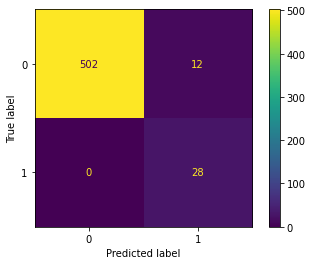

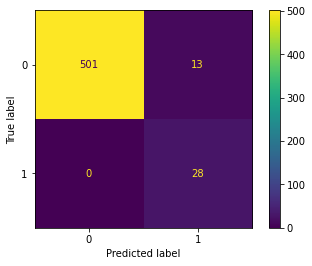

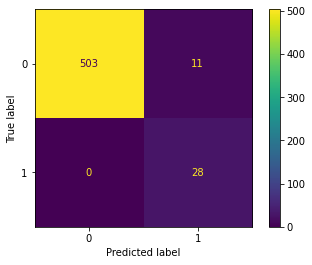

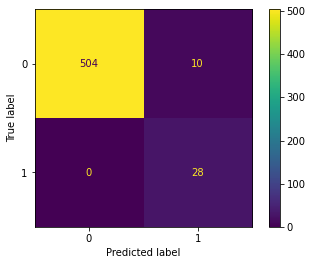

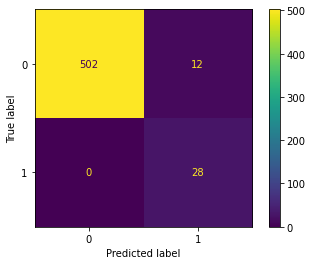

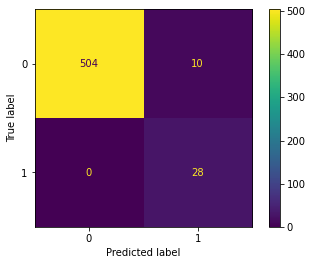

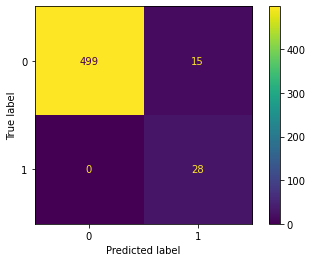

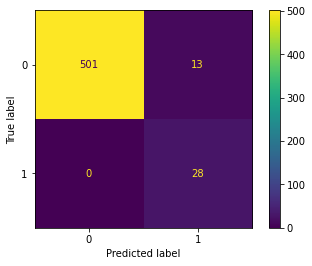

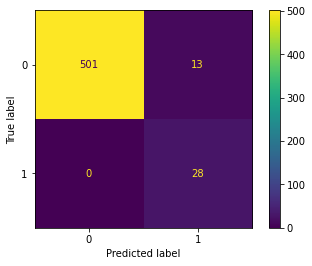

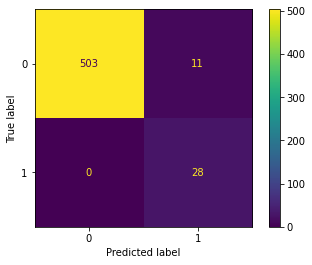

In [31]:
hidden_size = [128]
lr = [0.01]
weight_decay = [0.0005]
class_weight = [np.array([0.1,0.8])]

combinations = list(itertools.product(hidden_size, lr, weight_decay, class_weight))
binary_f1_scores = []
macro_f1_scores = []
final_combinations = []

for comb in tqdm(combinations):
    for _ in range(10):
        hidden_size = comb[0]
        lr = comb[1]
        weight_decay = comb[2]
        class_weight = comb[3]
        try:
            model = GCN(x.shape[1], hidden_size,2)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 400, gamma=0.1)
            criterion = torch.nn.CrossEntropyLoss(weight = torch.from_numpy(class_weight))
            num_epochs = 1000
            train(model, edge_index, x, y, num_epochs, criterion, optimizer, train_mask, val_mask, test_mask)                                     

            
            binary_f1, macro_f1 = test(model, edge_index, x, y, test_mask)
            binary_f1_scores.append(binary_f1)  
            macro_f1_scores.append(macro_f1)
            final_combinations.append(comb)
        except:
            continue

In [33]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1"] = binary_f1_scores
df["Test Macro F1"] = macro_f1_scores
df.rename(columns = {0: 'Hidden_size',
                     1: "Learning rate",
                     2: "Weight decay",
                     3: "Class Weight"}, inplace = True)
df = df.sort_values(by=['Test Binary F1'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(10)

,Hidden_size,Learning rate,Weight decay,Class Weight,Test Binary F1,Test Macro F1
0,128,0.01,0.0005,"[0.1, 0.8]",0.848485,0.919331
1,128,0.01,0.0005,"[0.1, 0.8]",0.848485,0.919331
2,128,0.01,0.0005,"[0.1, 0.8]",0.835821,0.912502
3,128,0.01,0.0005,"[0.1, 0.8]",0.835821,0.912502
4,128,0.01,0.0005,"[0.1, 0.8]",0.823529,0.905859
5,128,0.01,0.0005,"[0.1, 0.8]",0.823529,0.905859
6,128,0.01,0.0005,"[0.1, 0.8]",0.811594,0.899393
7,128,0.01,0.0005,"[0.1, 0.8]",0.811594,0.899393
8,128,0.01,0.0005,"[0.1, 0.8]",0.811594,0.899393
9,128,0.01,0.0005,"[0.1, 0.8]",0.788732,0.886962


In [34]:
print(f'The mean binary F1 of GCN: {df["Test Binary F1"].mean()} and the standard deviation: {df["Test Binary F1"].std()}')
print(f'The mean macro F1 of GCN: {df["Test Macro F1"].mean()} and the standard deviation: {df["Test Macro F1"].std()}')

The mean binary F1 of GCN: 0.8239185314605735 and the standard deviation: 0.018810088015057968
The mean macro F1 of GCN: 0.9060526751215191 and the standard deviation: 0.010183732016875864


# PyGOD algorithms

In [16]:
from pygod.models import DOMINANT
from pygod.metrics import eval_roc_auc

hidden_dim = [32,64,128]
num_layers = [8,16,64]
dropout = [0.2, 0.5]

combinations = list(itertools.product(hidden_dim,num_layers,dropout))
binary_f1_scores = []
macro_f1_scores = []
final_combinations = []

for comb in tqdm(combinations):
    for _ in range(1):
        hidden_dim = comb[0]
        num_layers = comb[1]
        dropout = comb[2]
        try:
            model = DOMINANT(hid_dim=hidden_dim, num_layers=num_layers, dropout=dropout) # hyperparameters can be set here
            model.fit(data)
            labels = model.predict(data)
            outlier_scores = model.decision_scores_
            auc_score = eval_roc_auc(data.y.numpy(), outlier_scores)
            print('AUC Score:', auc_score)
            binary_f1 = f1_score(data.y[test_mask], labels[test_mask], average = 'binary')
            macro_f1 = f1_score(data.y[test_mask], labels[test_mask], average = 'macro')
            binary_f1_scores.append(binary_f1)  
            macro_f1_scores.append(macro_f1)
            final_combinations.append(comb)
        except:
            print('Failed')
            continue

  0%|          | 0/18 [00:00<?, ?it/s]/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
  6%|▌         | 1/18 [00:02<00:46,  2.76s/it]

AUC Score: 0.8451390063723002


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 11%|█         | 2/18 [00:05<00:43,  2.72s/it]

AUC Score: 0.84571138555236


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 17%|█▋        | 3/18 [00:08<00:43,  2.92s/it]

AUC Score: 0.8457226639598489


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 22%|██▏       | 4/18 [00:11<00:41,  2.99s/it]

AUC Score: 0.8458072520160154


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 28%|██▊       | 5/18 [00:17<00:50,  3.89s/it]

AUC Score: 0.841408673095359


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 33%|███▎      | 6/18 [00:22<00:51,  4.32s/it]

AUC Score: 0.8414255907065922


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 39%|███▉      | 7/18 [00:25<00:42,  3.90s/it]

AUC Score: 0.8452320532340833


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 44%|████▍     | 8/18 [00:28<00:36,  3.70s/it]

AUC Score: 0.84479501494389


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 50%|█████     | 9/18 [00:32<00:33,  3.71s/it]

AUC Score: 0.845502735013816


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 56%|█████▌    | 10/18 [00:35<00:29,  3.67s/it]

AUC Score: 0.8459059380815428


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 61%|██████    | 11/18 [00:41<00:30,  4.29s/it]

AUC Score: 0.8420712795353297


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 67%|██████▋   | 12/18 [00:47<00:29,  4.87s/it]

AUC Score: 0.8406642982010939


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 72%|███████▏  | 13/18 [00:51<00:22,  4.54s/it]

AUC Score: 0.8460976710088536


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 78%|███████▊  | 14/18 [00:55<00:17,  4.32s/it]

AUC Score: 0.8450262222974115


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 83%|████████▎ | 15/18 [00:59<00:13,  4.38s/it]

AUC Score: 0.8453420177070998


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 89%|████████▉ | 16/18 [01:04<00:08,  4.45s/it]

AUC Score: 0.8457113855523601


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
 94%|█████████▍| 17/18 [01:13<00:05,  5.80s/it]

AUC Score: 0.8414396887159532


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
100%|██████████| 18/18 [01:22<00:00,  4.60s/it]

AUC Score: 0.8412169401680484


In [17]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1"] = binary_f1_scores
df["Test Macro F1"] = macro_f1_scores
df.rename(columns = {0: 'Hidden Dimension',
                     1: "Num Layers",
                     2: "Dropout"
                     }, inplace = True)
df = df.sort_values(by=['Test Binary F1'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(18)

,Hidden Dimension,Num Layers,Dropout,Test Binary F1,Test Macro F1
0,32,8,0.2,0.333333,0.627491
1,32,64,0.5,0.333333,0.625173
2,128,16,0.2,0.333333,0.620448
3,64,16,0.2,0.333333,0.620448
4,64,16,0.5,0.333333,0.622825
5,32,16,0.2,0.333333,0.622825
6,64,8,0.2,0.330709,0.620945
7,128,8,0.2,0.328358,0.616811
8,64,8,0.5,0.327869,0.621315
9,64,64,0.2,0.327586,0.623504


In [18]:
from pygod.models import DOMINANT
from pygod.metrics import eval_roc_auc

hidden_dim = [32]
num_layers = [8]
dropout = [0.2]

combinations = list(itertools.product(hidden_dim,num_layers,dropout))
binary_f1_scores = []
macro_f1_scores = []
final_combinations = []

for comb in tqdm(combinations):
    for _ in range(10):
        hidden_dim = comb[0]
        num_layers = comb[1]
        dropout = comb[2]
        try:
            model = DOMINANT(hid_dim=hidden_dim, num_layers=num_layers, dropout=dropout) # hyperparameters can be set here
            model.fit(data)
            labels = model.predict(data)
            outlier_scores = model.decision_scores_
            auc_score = eval_roc_auc(data.y.numpy(), outlier_scores)
            print('AUC Score:', auc_score)
            binary_f1 = f1_score(data.y[test_mask], labels[test_mask], average = 'binary')
            macro_f1 = f1_score(data.y[test_mask], labels[test_mask], average = 'macro')
            binary_f1_scores.append(binary_f1)  
            macro_f1_scores.append(macro_f1)
            final_combinations.append(comb)
        except:
            print('Failed')
            continue

  0%|          | 0/1 [00:00<?, ?it/s]/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


AUC Score: 0.8457226639598489


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


AUC Score: 0.8457536795804433


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


AUC Score: 0.845880561664693


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


AUC Score: 0.8452320532340833


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


AUC Score: 0.845370213725822


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


AUC Score: 0.8458100716178876


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


AUC Score: 0.8458918400721818


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


AUC Score: 0.8453645745220775


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')


AUC Score: 0.8456803699317655


/opt/anaconda3/envs/torchgeometric/lib/python3.10/site-packages/pygod/utils/utility.py:52: UserWarning: The cuda is not available. Set to cpu.
  warnings.warn('The cuda is not available. Set to cpu.')
100%|██████████| 1/1 [00:28<00:00, 28.93s/it]

AUC Score: 0.845855185247843


In [20]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1"] = binary_f1_scores
df["Test Macro F1"] = macro_f1_scores
df.rename(columns = {0: 'Hidden Dimension',
                     1: "Num Layers",
                     2: "Dropout"
                     }, inplace = True)
df = df.sort_values(by=['Test Binary F1'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(10)

,Hidden Dimension,Num Layers,Dropout,Test Binary F1,Test Macro F1
0,32,8,0.2,0.333333,0.627491
1,32,8,0.2,0.325926,0.615018
2,32,8,0.2,0.325581,0.617241
3,32,8,0.2,0.323529,0.613241
4,32,8,0.2,0.322581,0.604778
5,32,8,0.2,0.322581,0.617540
6,32,8,0.2,0.320000,0.615683
7,32,8,0.2,0.311927,0.617502
8,32,8,0.2,0.306306,0.613585
9,32,8,0.2,0.306306,0.613585


In [21]:
print(f'The mean binary F1 of DOMINANT: {df["Test Binary F1"].mean()} and the standard deviation: {df["Test Binary F1"].std()}')
print(f'The mean macro F1 of DOMINANT: {df["Test Macro F1"].mean()} and the standard deviation: {df["Test Macro F1"].std()}')

The mean binary F1 of DOMINANT: 0.31980705748125826 and the standard deviation: 0.008879842845680061
The mean macro F1 of DOMINANT: 0.6155664274341122 and the standard deviation: 0.005603728585642442


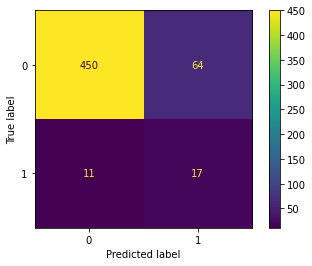

In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(data.y[test_mask], labels[test_mask], normalize = 'true')
cm = confusion_matrix(data.y[test_mask], labels[test_mask])
disp = ConfusionMatrixDisplay(cm)
disp.plot()

# Node2Vec

https://github.com/eliorc/node2vec

In [34]:
path = 'inj_cora.pt'
G = read_from_pyg(path)

### Gridsearch on Node2Vec

  0%|          | 0/12 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

  8%|▊         | 1/12 [00:12<02:18, 12.55s/it]

Binary test F1: 0.09187279151943462
Macro test F1: 0.38551192634648385


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [01:08<06:18, 37.81s/it]

Binary test F1: 0.08633093525179857
Macro test F1: 0.38559722941249974


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [01:20<03:56, 26.32s/it]

Binary test F1: 0.10743801652892564
Macro test F1: 0.42545297501030604


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

 33%|███▎      | 4/12 [02:18<05:10, 38.80s/it]

Binary test F1: 0.0873015873015873
Macro test F1: 0.40542963980463986


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [02:31<03:25, 29.41s/it]

Binary test F1: 0.07857142857142856
Macro test F1: 0.37883795309168444


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

 50%|█████     | 6/12 [03:27<03:51, 38.62s/it]

Binary test F1: 0.056939501779359435
Macro test F1: 0.3634635242396174


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

 58%|█████▊    | 7/12 [03:40<02:30, 30.17s/it]

Binary test F1: 0.07092198581560284
Macro test F1: 0.37211934702251465


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

 67%|██████▋   | 8/12 [04:37<02:34, 38.66s/it]

Binary test F1: 0.10566037735849057
Macro test F1: 0.4081415439906006


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

 75%|███████▌  | 9/12 [04:50<01:31, 30.53s/it]

Binary test F1: 0.0966542750929368
Macro test F1: 0.3992473829452414


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

 83%|████████▎ | 10/12 [05:45<01:16, 38.27s/it]

Binary test F1: 0.09737827715355807
Macro test F1: 0.4011983185033396


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

 92%|█████████▏| 11/12 [05:58<00:30, 30.52s/it]

Binary test F1: 0.06818181818181818
Macro test F1: 0.38409090909090915


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

100%|██████████| 12/12 [06:55<00:00, 34.66s/it]

Binary test F1: 0.08474576271186442
Macro test F1: 0.4150143907898945


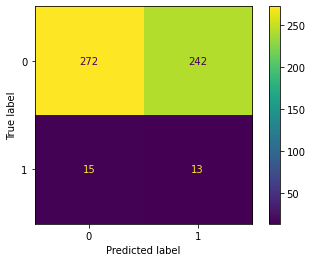

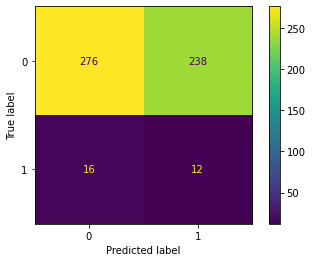

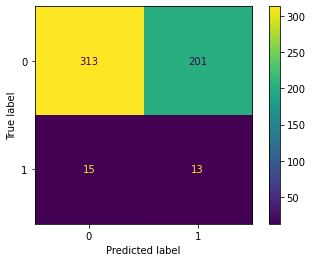

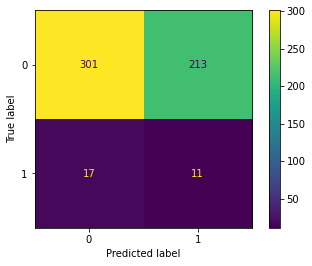

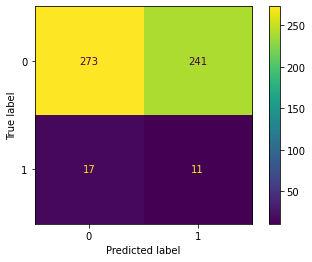

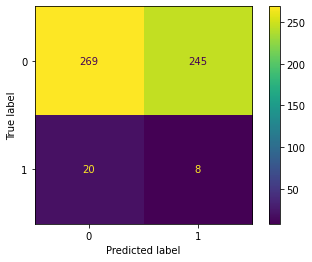

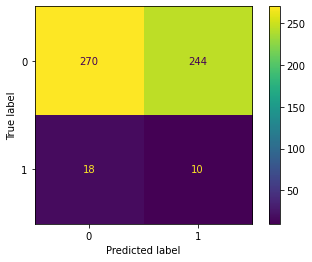

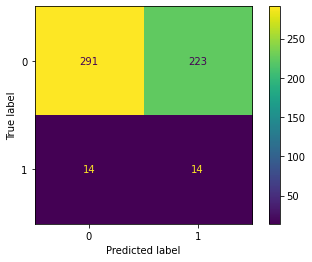

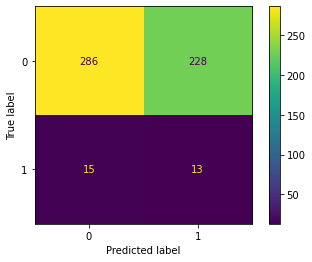

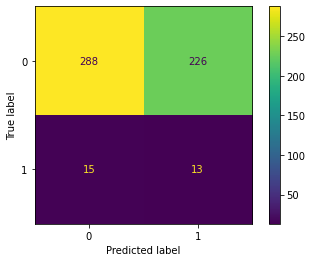

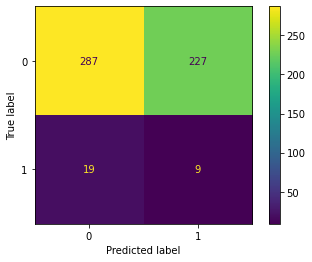

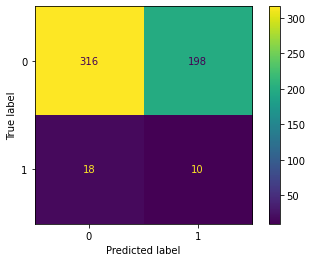

In [25]:
windws = [2,5,10]
dimensions = [10,20] # Lower dimensions seem to perform better
num_walks = [10,50]
walk_length = [50]

combinations = list(itertools.product(windws, dimensions, num_walks, walk_length))
binary_f1_scores = []
macro_f1_scores = []
final_combinations = []

for comb in tqdm(combinations):
    window = comb[0]
    dims = comb[1]
    num_walks = comb[2]
    walk_length = comb[3]
    
    try:
        node2vec = Node2Vec(G, dimensions=dims, walk_length=walk_length, num_walks=num_walks, workers=8)
        model = node2vec.fit(window=2, min_count=1, batch_words=4)
        embeddings = np.asarray([model.wv[node] for node in list(G.nodes())])
        binary_f1, macro_f1 = predict(G,embeddings, return_f1_score = True, model = 'lr')
        binary_f1_scores.append(binary_f1)  
        macro_f1_scores.append(macro_f1)
        final_combinations.append(comb)
    except:
        continue

Node2Vec results with logistic regression

In [26]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1"] = binary_f1_scores
df["Test Macro F1"] = macro_f1_scores
df.rename(columns = {0: 'Window',
                     1: "Dimension",
                     2: "Number of walks",
                     3: "Walk Length"}, inplace = True)
df = df.sort_values(by=['Test Binary F1'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(30)

,Window,Dimension,Number of walks,Walk Length,Test Binary F1,Test Macro F1
0,2,20,10,50,0.107438,0.425453
1,5,20,50,50,0.105660,0.408142
2,10,10,50,50,0.097378,0.401198
3,10,10,10,50,0.096654,0.399247
4,2,10,10,50,0.091873,0.385512
5,2,20,50,50,0.087302,0.405430
6,2,10,50,50,0.086331,0.385597
7,10,20,50,50,0.084746,0.415014
8,5,10,10,50,0.078571,0.378838
9,5,20,10,50,0.070922,0.372119


  0%|          | 0/1 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


Binary test F1: 0.09386281588447654
Macro test F1: 0.3914171576324489
Binary test F1: 0.0
Macro test F1: 0.4818355640535372


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Binary test F1: 0.078125
Macro test F1: 0.396550422705314
Binary test F1: 0.0
Macro test F1: 0.48430066603235017


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


Binary test F1: 0.05714285714285715
Macro test F1: 0.39090754299335945
Binary test F1: 0.0
Macro test F1: 0.48479087452471487


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


Binary test F1: 0.06666666666666667
Macro test F1: 0.4006319115323855
Binary test F1: 0.0
Macro test F1: 0.4852801519468186


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


Binary test F1: 0.13333333333333333
Macro test F1: 0.433373542420587
Binary test F1: 0.0
Macro test F1: 0.4838095238095238


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


Binary test F1: 0.05809128630705394
Macro test F1: 0.39440744623775
Binary test F1: 0.0
Macro test F1: 0.48479087452471487


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


Binary test F1: 0.10566037735849057
Macro test F1: 0.4081415439906006
Binary test F1: 0.0
Macro test F1: 0.4828244274809161


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


Binary test F1: 0.072992700729927
Macro test F1: 0.3797062269081734
Binary test F1: 0.0
Macro test F1: 0.48430066603235017


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


Binary test F1: 0.07773851590106007
Macro test F1: 0.3759479096359233
Binary test F1: 0.0
Macro test F1: 0.4828244274809161


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Generating walks (CPU: 8): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


Binary test F1: 0.10526315789473684
Macro test F1: 0.4071548063312315


100%|██████████| 1/1 [02:10<00:00, 130.18s/it]

Binary test F1: 0.0
Macro test F1: 0.4852801519468186


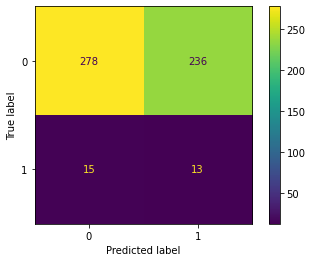

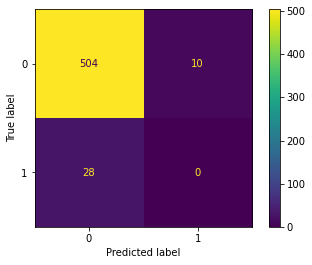

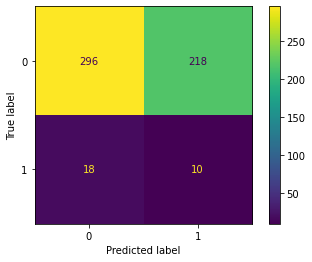

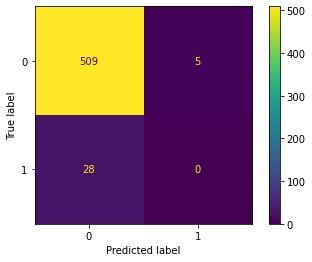

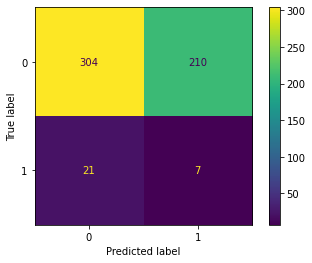

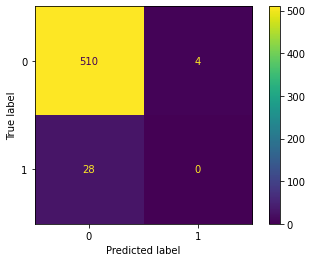

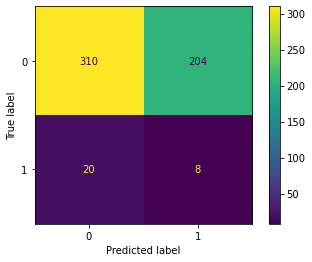

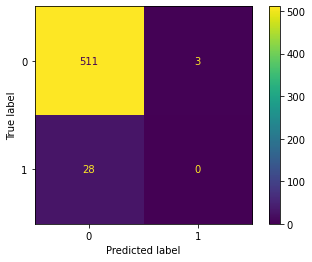

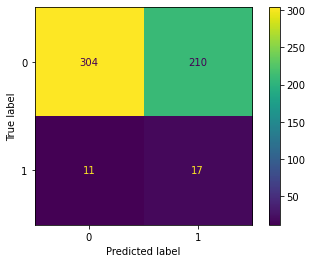

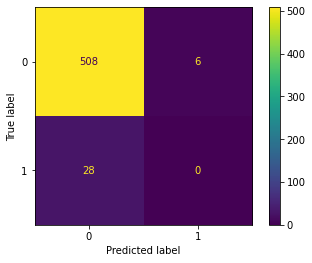

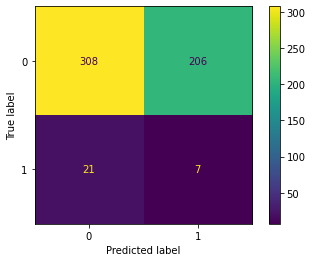

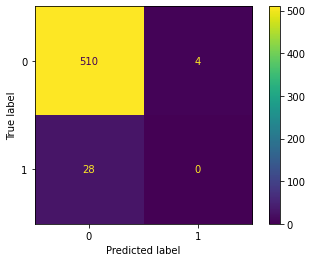

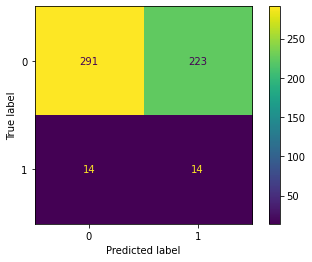

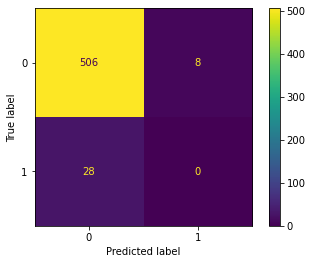

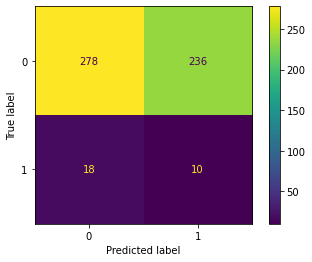

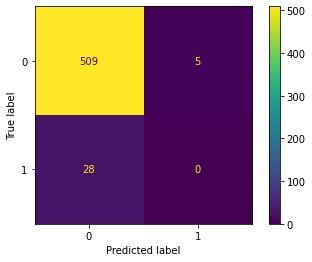

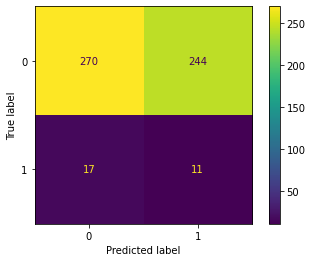

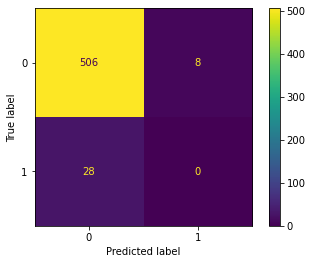

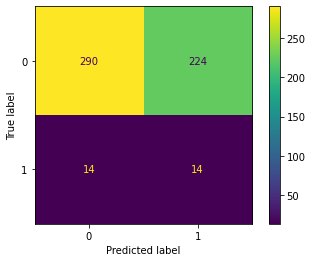

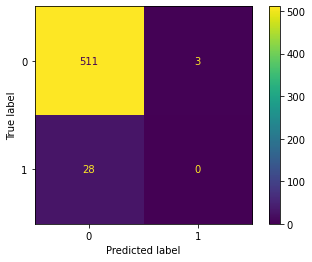

In [29]:
windws = [2]
dimensions = [20]
num_walks = [10]
walk_length = [50]

combinations = list(itertools.product(windws, dimensions, num_walks, walk_length))
binary_f1_scores_lr = []
macro_f1_scores_lr = []
binary_f1_scores_xgb = []
macro_f1_scores_xgb = []
final_combinations = []

for comb in tqdm(combinations):
    window = comb[0]
    dims = comb[1]
    num_walks = comb[2]
    walk_length = comb[3]
    for _ in range(10):
        try:
            node2vec = Node2Vec(G, dimensions=dims, walk_length=walk_length, num_walks=num_walks, workers=8)
            model = node2vec.fit(window=2, min_count=1, batch_words=4)
            embeddings = np.asarray([model.wv[node] for node in list(G.nodes())])
            binary_f1_lr, macro_f1_lr = predict(G,embeddings, return_f1_score = True, model = 'lr')
            binary_f1_xgb, macro_f1_xgb = predict(G,embeddings, return_f1_score = True, model = 'xgb')
            binary_f1_scores_lr.append(binary_f1_lr)  
            macro_f1_scores_lr.append(macro_f1_lr)
            binary_f1_scores_xgb.append(binary_f1_xgb)  
            macro_f1_scores_xgb.append(macro_f1_xgb)
            final_combinations.append(comb)
        except:
            continue

In [30]:
df = pd.DataFrame([list(c) for c in final_combinations])
df["Test Binary F1 Logistic Regression"] = binary_f1_scores_lr
df["Test Macro F1 Logistic Regression"] = macro_f1_scores_lr
df["Test Binary F1 XGB"] = binary_f1_scores_xgb
df["Test Macro F1 XGB"] = macro_f1_scores_xgb
df.rename(columns = {0: 'Window',
                     1: "Dimension",
                     2: "Number of walks",
                     3: "Walk Length"}, inplace = True)
df = df.sort_values(by=['Test Binary F1 Logistic Regression'], ascending = False).reset_index()
df = df.drop(columns = ["index"])
df.head(30)

,Window,Dimension,Number of walks,Walk Length,Test Binary F1 Logistic Regression,Test Macro F1 Logistic Regression,Test Binary F1 XGB,Test Macro F1 XGB
0,2,20,10,50,0.133333,0.433374,0.0,0.483810
1,2,20,10,50,0.105660,0.408142,0.0,0.482824
2,2,20,10,50,0.105263,0.407155,0.0,0.485280
3,2,20,10,50,0.093863,0.391417,0.0,0.481836
4,2,20,10,50,0.078125,0.396550,0.0,0.484301
5,2,20,10,50,0.077739,0.375948,0.0,0.482824
6,2,20,10,50,0.072993,0.379706,0.0,0.484301
7,2,20,10,50,0.066667,0.400632,0.0,0.485280
8,2,20,10,50,0.058091,0.394407,0.0,0.484791
9,2,20,10,50,0.057143,0.390908,0.0,0.484791


In [32]:
print(f'The mean binary F1 of Node2Vec: {df["Test Binary F1 Logistic Regression"].mean()} and the standard deviation: {df["Test Binary F1 Logistic Regression"].std()}')
print(f'The mean macro F1 of Node2Vec: {df["Test Macro F1 Logistic Regression"].mean()} and the standard deviation: {df["Test Macro F1 Logistic Regression"].std()}')

The mean binary F1 of Node2Vec: 0.08488767112186021 and the standard deviation: 0.024341007016442297
The mean macro F1 of Node2Vec: 0.3978238510387774 and the standard deviation: 0.016241807749896076


TSNE succesfully applied: x now of shape: (2708, 2)


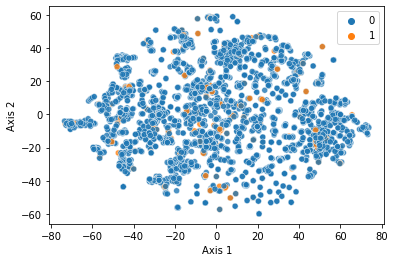

<Figure size 720x720 with 0 Axes>

In [33]:
visualize(G, embeddings, labeled=True)

# Traditional ML on graph structure and node features

In [82]:
from pygod.utils import load_data
data = load_data('inj_cora')

x = pd.DataFrame(data.x)

y = data.y # 138 nodes have label 1
y[np.where(y == 2)] = 1
y[np.where(y == 3)] = 1

In [83]:
class FeatureEngineering():
    
    '''
    We make a class with the feature engineering so that this can happen automatically for training and test.
    After this, we have a dataframe with features on which we can apply classical ML algorithms. 
    
    '''
    
    def __init__(self, G, data ,train = True):
        '''
        G: the train graph in which the edges were defined
        data: the features corresponding to each node
        train: whether training set or not. 
        '''
        
        self.G = G
        self.train = train
        self.data = data
        
    def node_features(self):
        '''
        Calculate individual node features and concatenate them into a dataframe with the node id as index
        '''

        degree = pd.Series(nx.degree_centrality(self.G))
        closeness = pd.Series(nx.closeness_centrality(self.G))
        eigen_centrality = pd.Series(nx.eigenvector_centrality(self.G, max_iter = 500))
        clustering_coef = pd.Series(nx.clustering(self.G))
        betweeness_centrality = pd.Series(nx.betweenness_centrality(self.G))
        # concat_graph_feat  is a dataframe where each row is indexed by the node and the row
        # contains all features for that node. 
        features = pd.concat([
                degree,
                closeness,
                eigen_centrality,
                clustering_coef,
                betweeness_centrality, self.data],
                axis = 1,
                join = "inner")
        features.columns = list(range(len(features.columns)))
        return features
    
    def normalize(self,df):
        normalized_df = (df-df.mean())/df.std()
        return normalized_df
        

In [84]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42,shuffle=True, stratify=y)

In [85]:
feature_engineering_train = FeatureEngineering(G,X_train)
feature_engineering_test = FeatureEngineering(G,X_test)

X_train = feature_engineering_train.node_features()
X_test = feature_engineering_test.node_features()

In [86]:
def predict(train_df, train_label, test_df,test_label, clf):
    scores = cross_val_score(clf, train_df,train_label, cv = 5, scoring = 'f1')
    clf.fit(train_df,train_label)
    train_preds = clf.predict(train_df)
    test_preds = clf.predict(test_df)
    print(f'We predict {sum(train_preds) + sum(test_preds)} outliers')
    f1 = f1_score(test_label,test_preds, average = 'micro')
    print(f'The F1-score on the test set is {f1}')


In [87]:
clf = LogisticRegression(class_weight = 'balanced')
predict(X_train,y_train,X_test, y_test,clf)

[0.10204082 0.11111111 0.09638554 0.04225352 0.05333333]
We predict 535 outliers
The F1-score on the test set is 0.7804428044280443


In [88]:
clf = RandomForestClassifier(n_estimators = 200,class_weight = 'balanced')
predict(X_train,y_train,X_test, y_test,clf)

[0. 0. 0. 0. 0.]
We predict 112 outliers
The F1-score on the test set is 0.948339483394834


In [89]:
clf = XGBClassifier(max_depth = 10,scale_pos_weight = 90)
predict(X_train,y_train,X_test, y_test,clf)

[0.         0.06666667 0.08333333 0.         0.0625    ]
We predict 122 outliers
The F1-score on the test set is 0.9372693726937269
